# Analisis Clustering Komprehensif: DASS-42 DATA

Notebook ini melakukan analisis clustering lengkap menggunakan data Depression Anxiety Stress Scales (DASS-42). Ini mencakup perbandingan antara algoritma K-Means dan Gaussian Mixture Model (GMM), dengan dan tanpa penerapan teknik oversampling ADASYN.

## Bagian 1: Data Analyst & Data Engineer

### 0. Inisialisasi dan Import Library

Sel ini mengimpor semua library yang diperlukan untuk analisis data, pra-pemrosesan, clustering, evaluasi, dan visualisasi. Konfigurasi awal untuk plotting juga diatur di sini.

In [ ]:
"""
Analisis Clustering Lengkap: Perbandingan K-Means dan GMM dengan dan tanpa ADASYN
Data: Depression Anxiety Stress Scales (DASS-42)
"""

import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split # Meskipun tidak digunakan secara eksplisit untuk train/test split di clustering, ini adalah import umum
import warnings

warnings.filterwarnings('ignore')

# Konfigurasi plotting
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Library berhasil diimpor dan konfigurasi plotting diatur.")

Library berhasil diimpor dan konfigurasi plotting diatur.


### 1. Pemuatan Data & Eksplorasi Awal

Memuat dataset DASS-42 dari Kaggle dan melakukan eksplorasi awal untuk memahami dimensi data, kolom yang tersedia, dan keberadaan nilai yang hilang.

In [ ]:
print("\n### 1. Pemuatan Data & Eksplorasi Awal")
print("="*80)
print("ANALISIS CLUSTERING KOMPREHENSIF: DASS-42 DATA")
print("="*80)

print("\n1. LOADING DATA...")
try:
    path = kagglehub.dataset_download("lucasgreenwell/depression-anxiety-stress-scales-responses")
    data_file_path = f"{path}/data.csv"
    df = pd.read_csv(data_file_path, sep='\t', engine='python') # Menambahkan engine='python' jika ada masalah parsing

    print(f"Dataset dimuat: {df.shape[0]} responden, {df.shape[1]} kolom")
    print(f"Kolom tersedia: {len(df.columns)} kolom")
    # Memeriksa data kosong di seluruh dataframe
    total_missing_values = df.isnull().sum().sum()
    print(f"Total nilai kosong di seluruh dataset: {total_missing_values}")
    print(f"Baris dengan setidaknya satu nilai kosong: {len(df[df.isnull().any(axis=1)])} baris")

    print("\nContoh data (5 baris pertama):")
    print(df.head())
    print("\nInformasi dataset:")
    df.info()
except Exception as e:
    print(f"Error saat memuat data dari Kaggle: {e}")
    print("Pastikan Anda memiliki koneksi internet dan kagglehub terkonfigurasi dengan benar.")
    print("Alternatif: Coba muat dari path lokal jika file sudah diunduh.")
    # Contoh fallback jika ingin memuat dari lokal:
    # local_path = 'path/to/your/data.csv'
    # try:
    #     df = pd.read_csv(local_path, sep='\t')
    #     print(f"Dataset berhasil dimuat dari path lokal: {local_path}")
    #     print(f"Dataset dimuat: {df.shape[0]} responden, {df.shape[1]} kolom")
    # except Exception as e_local:
    #     print(f"Gagal memuat data dari path lokal: {e_local}")
    #     df = None
    df = None


### 1. Pemuatan Data & Eksplorasi Awal
ANALISIS CLUSTERING KOMPREHENSIF: DASS-42 DATA

1. LOADING DATA...
Dataset dimuat: 39775 responden, 172 kolom
Kolom tersedia: 172 kolom
Total nilai kosong di seluruh dataset: 11427
Baris dengan setidaknya satu nilai kosong: 11426 baris

Contoh data (5 baris pertama):
   Q1A  Q1I   Q1E  Q2A  Q2I   Q2E  Q3A  Q3I   Q3E  Q4A  ...  screensize  \
0    4   28  3890    4   25  2122    2   16  1944    4  ...           1   
1    4    2  8118    1   36  2890    2   35  4777    3  ...           2   
2    3    7  5784    1   33  4373    4   41  3242    1  ...           2   
3    2   23  5081    3   11  6837    2   37  5521    1  ...           2   
4    2   36  3215    2   13  7731    3    5  4156    4  ...           2   

   uniquenetworklocation  hand  religion  orientation  race  voted  married  \
0                      1     1        12            1    10      2        1   
1                      1     2         7            0    70      2        1   
2   

### 2. Pra-pemrosesan & Penyaringan Data

Melakukan penyaringan data berdasarkan Vocabulary Check List (VCL) untuk menghapus responden yang tidak valid. Mendefinisikan kolom fitur yang akan digunakan untuk analisis dan menyiapkan dataset final dengan menghapus nilai yang hilang pada fitur kesehatan mental.

In [ ]:
print("\n### 2. Pra-pemrosesan & Penyaringan Data")
if df is not None:
    print("\n2. DATA PREPROCESSING...")
    df_filtered = df.copy()

    # Filter berdasarkan Vocabulary Check List (VCL)
    vcl_cols = [f'VCL{i}' for i in range(1, 17)] # Asumsi VCL1 sampai VCL16
    # Item non-kata yang valid (responden harus menjawab 0)
    # Dari metadata sumber: VCL6, VCL9, VCL12 adalah non-kata.
    # Jika responden menandai ini sebagai kata yang diketahui (nilai 1), mereka tidak valid.
    # Kolom VCL lainnya adalah kata-kata nyata, jadi jika responden menandainya sebagai tidak diketahui (nilai 0), itu juga bisa jadi indikasi.
    # Namun, instruksi asli hanya fokus pada VCL6, VCL9, VCL12.

    # Memastikan kolom VCL ada sebelum filtering
    valid_vcl_cols_for_filter = ['VCL6', 'VCL9', 'VCL12']
    missing_vcl_filter_cols = [col for col in valid_vcl_cols_for_filter if col not in df_filtered.columns]
    if missing_vcl_filter_cols:
        print(f"Peringatan: Kolom VCL berikut untuk filter tidak ditemukan: {missing_vcl_filter_cols}. Filter VCL mungkin tidak akurat.")
    else:
        invalid_vcl_mask = (df_filtered['VCL6'] == 1) | \
                           (df_filtered['VCL9'] == 1) | \
                           (df_filtered['VCL12'] == 1)
        rows_before_vcl = len(df_filtered)
        df_filtered = df_filtered[~invalid_vcl_mask]
        rows_after_vcl = len(df_filtered)
        print(f"Filter VCL: {rows_before_vcl - rows_after_vcl} responden tidak valid dihapus")

    # Definisi kolom fitur
    health_features_cols = [f'Q{i}A' for i in range(1, 43)] # Jawaban DASS

    # Memastikan semua kolom health_features_cols ada
    missing_health_cols = [col for col in health_features_cols if col not in df_filtered.columns]
    if missing_health_cols:
        print(f"Peringatan: Kolom kesehatan berikut tidak ditemukan dan akan diabaikan: {missing_health_cols}")
        health_features_cols = [col for col in health_features_cols if col in df_filtered.columns]

    profiling_cols_candidates = ['education', 'urban', 'gender', 'age', 'hand', 'religion',
                                 'orientation', 'race', 'voted', 'married', 'familysize'] + \
                                [f'TIPI{i}' for i in range(1, 11)] # Ten Item Personality Inventory

    profiling_cols = [col for col in profiling_cols_candidates if col in df_filtered.columns]
    missing_profiling_cols = [col for col in profiling_cols_candidates if col not in df_filtered.columns]
    if missing_profiling_cols:
         print(f"Peringatan: Kolom profiling berikut tidak ditemukan dan akan diabaikan: {missing_profiling_cols}")

    # Preparasi data final
    # Hanya menggunakan kolom fitur kesehatan dan profil yang ada, dan menghapus baris dengan NaN di fitur kesehatan

    # Periksa apakah health_features_cols tidak kosong
    if not health_features_cols:
        print("Error: Tidak ada kolom fitur kesehatan (DASS QnA) yang valid ditemukan. Tidak dapat melanjutkan.")
        df_final = None
    else:
        df_final = df_filtered[health_features_cols + profiling_cols].copy()

        # Menghapus baris dengan NaN *hanya* pada kolom fitur kesehatan yang akan digunakan untuk clustering
        rows_before_nan_health = len(df_final)
        df_final.dropna(subset=health_features_cols, inplace=True)
        rows_after_nan_health = len(df_final)
        print(f"Penghapusan NaN pada fitur kesehatan: {rows_before_nan_health - rows_after_nan_health} baris dihapus.")

        # Mengisi NaN pada kolom profiling dengan modus (untuk kategorikal) atau median (untuk numerik)
        # Ini dilakukan agar tidak kehilangan terlalu banyak data karena NaN di kolom profiling
        # Namun, untuk clustering, kita hanya akan menggunakan health_features_cols yang sudah di-dropna
        for col in profiling_cols:
            if df_final[col].isnull().any():
                if df_final[col].dtype == 'object' or df_final[col].nunique() < 15: # Asumsi kategorikal
                    mode_val = df_final[col].mode()[0]
                    df_final[col].fillna(mode_val, inplace=True)
                    # print(f"Kolom profiling '{col}' (kategorikal) diisi NaN dengan modus: {mode_val}")
                else: # Asumsi numerik
                    median_val = df_final[col].median()
                    df_final[col].fillna(median_val, inplace=True)
                    # print(f"Kolom profiling '{col}' (numerik) diisi NaN dengan median: {median_val}")

        print(f"Data final: {df_final.shape[0]} responden dengan {len(health_features_cols)} fitur kesehatan mental")
        print("\nContoh data final (5 baris pertama):")
        print(df_final.head())
        print("\nInfo data final setelah penanganan NaN di kolom profiling:")
        df_final.info()

else:
    print("Dataset tidak termuat, langkah pra-pemrosesan dilewati.")
    df_final = None



### 2. Pra-pemrosesan & Penyaringan Data

2. DATA PREPROCESSING...
Filter VCL: 5192 responden tidak valid dihapus
Penghapusan NaN pada fitur kesehatan: 0 baris dihapus.
Data final: 34583 responden dengan 42 fitur kesehatan mental

Contoh data final (5 baris pertama):
   Q1A  Q2A  Q3A  Q4A  Q5A  Q6A  Q7A  Q8A  Q9A  Q10A  ...  TIPI1  TIPI2  \
0    4    4    2    4    4    4    4    4    2     1  ...      1      5   
1    4    1    2    3    4    4    3    4    3     2  ...      6      5   
2    3    1    4    1    4    3    1    3    2     4  ...      2      5   
3    2    3    2    1    3    3    4    2    3     3  ...      1      1   
4    2    2    3    4    4    2    4    4    4     3  ...      2      5   

   TIPI3  TIPI4  TIPI5  TIPI6  TIPI7  TIPI8  TIPI9  TIPI10  
0      7      7      7      7      7      5      1       1  
1      4      7      5      4      7      7      1       5  
2      2      2      5      6      5      5      3       2  
3      7      4      6      4      6

### 3. Penskalaan Fitur

Menerapkan StandardScaler pada fitur-fitur kesehatan mental (DASS-42) untuk memastikan semua fitur memiliki skala yang sama, yang penting untuk algoritma berbasis jarak seperti K-Means.

In [ ]:
print("\n### 3. Penskalaan Fitur")
X_scaled = None
if df_final is not None and health_features_cols:
    print("\n3. FEATURE SCALING...")
    # Pastikan tidak ada NaN yang tersisa di health_features_cols sebelum scaling
    if df_final[health_features_cols].isnull().sum().sum() > 0:
        print("Peringatan: Masih ada nilai NaN di health_features_cols sebelum scaling. Ini seharusnya sudah ditangani.")
        print("Menjalankan dropna lagi pada subset health_features_cols untuk df_final yang akan di-scale.")
        df_final.dropna(subset=health_features_cols, inplace=True)
        # Pastikan df_final tidak menjadi kosong
        if df_final.empty:
            print("Error: df_final menjadi kosong setelah dropna tambahan. Tidak dapat melanjutkan.")
            X_scaled = None # atau df_final = None
        else:
             print("Data setelah dropna tambahan:", df_final.shape)


    if not df_final.empty:
        X = df_final[health_features_cols].copy() # Bekerja dengan copy untuk menghindari SettingWithCopyWarning
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        print(f"Data berhasil di-scaling. Shape: {X_scaled.shape}")
        print("\nContoh data setelah scaling (5 baris pertama):")
        print(pd.DataFrame(X_scaled, columns=health_features_cols).head())
    else:
        print("Data final kosong setelah penanganan NaN, langkah penskalaan fitur dilewati.")
        X_scaled = None

else:
    print("Data final tidak tersedia atau tidak ada kolom fitur kesehatan, langkah penskalaan fitur dilewati.")
    X_scaled = None


### 3. Penskalaan Fitur

3. FEATURE SCALING...
Data berhasil di-scaling. Shape: (34583, 42)

Contoh data setelah scaling (5 baris pertama):
        Q1A       Q2A       Q3A       Q4A       Q5A       Q6A       Q7A  \
0  1.340379  1.653906 -0.206921  2.002229  1.403513  1.400492  2.051719   
1  1.340379 -1.053133 -0.206921  1.033821  1.403513  1.400492  1.072657   
2  0.367101 -1.053133  1.732623 -0.902994  1.403513  0.443957 -0.885468   
3 -0.606177  0.751560 -0.206921 -0.902994  0.465242  0.443957  2.051719   
4 -0.606177 -0.150787  0.762851  2.002229  1.403513 -0.512579  2.051719   

        Q8A       Q9A      Q10A  ...      Q33A      Q34A      Q35A      Q36A  \
0  1.471134 -0.624170 -1.267216  ... -0.378838  0.322677  1.727632  1.569995   
1  1.471134  0.314991 -0.385514  ...  0.578583 -0.548382 -0.292817  0.663126   
2  0.516232 -0.624170  1.377891  ... -1.336258  1.193736  0.717408  1.569995   
3 -0.438670  0.314991  0.496189  ... -0.378838  1.193736 -1.303042 -1.150611   
4  1.471

## Bagian 2: ML Engineer

### 4. Penjelasan Algoritma Clustering

Visualisasi dan penjelasan singkat mengenai cara kerja algoritma K-Means dan Gaussian Mixture Model (GMM).


4. PENJELASAN ALGORITMA CLUSTERING
Menggunakan data X_scaled yang direduksi dengan PCA untuk visualisasi penjelasan algoritma.
Data PCA (shape: (500, 2)) akan digunakan untuk plot penjelasan.


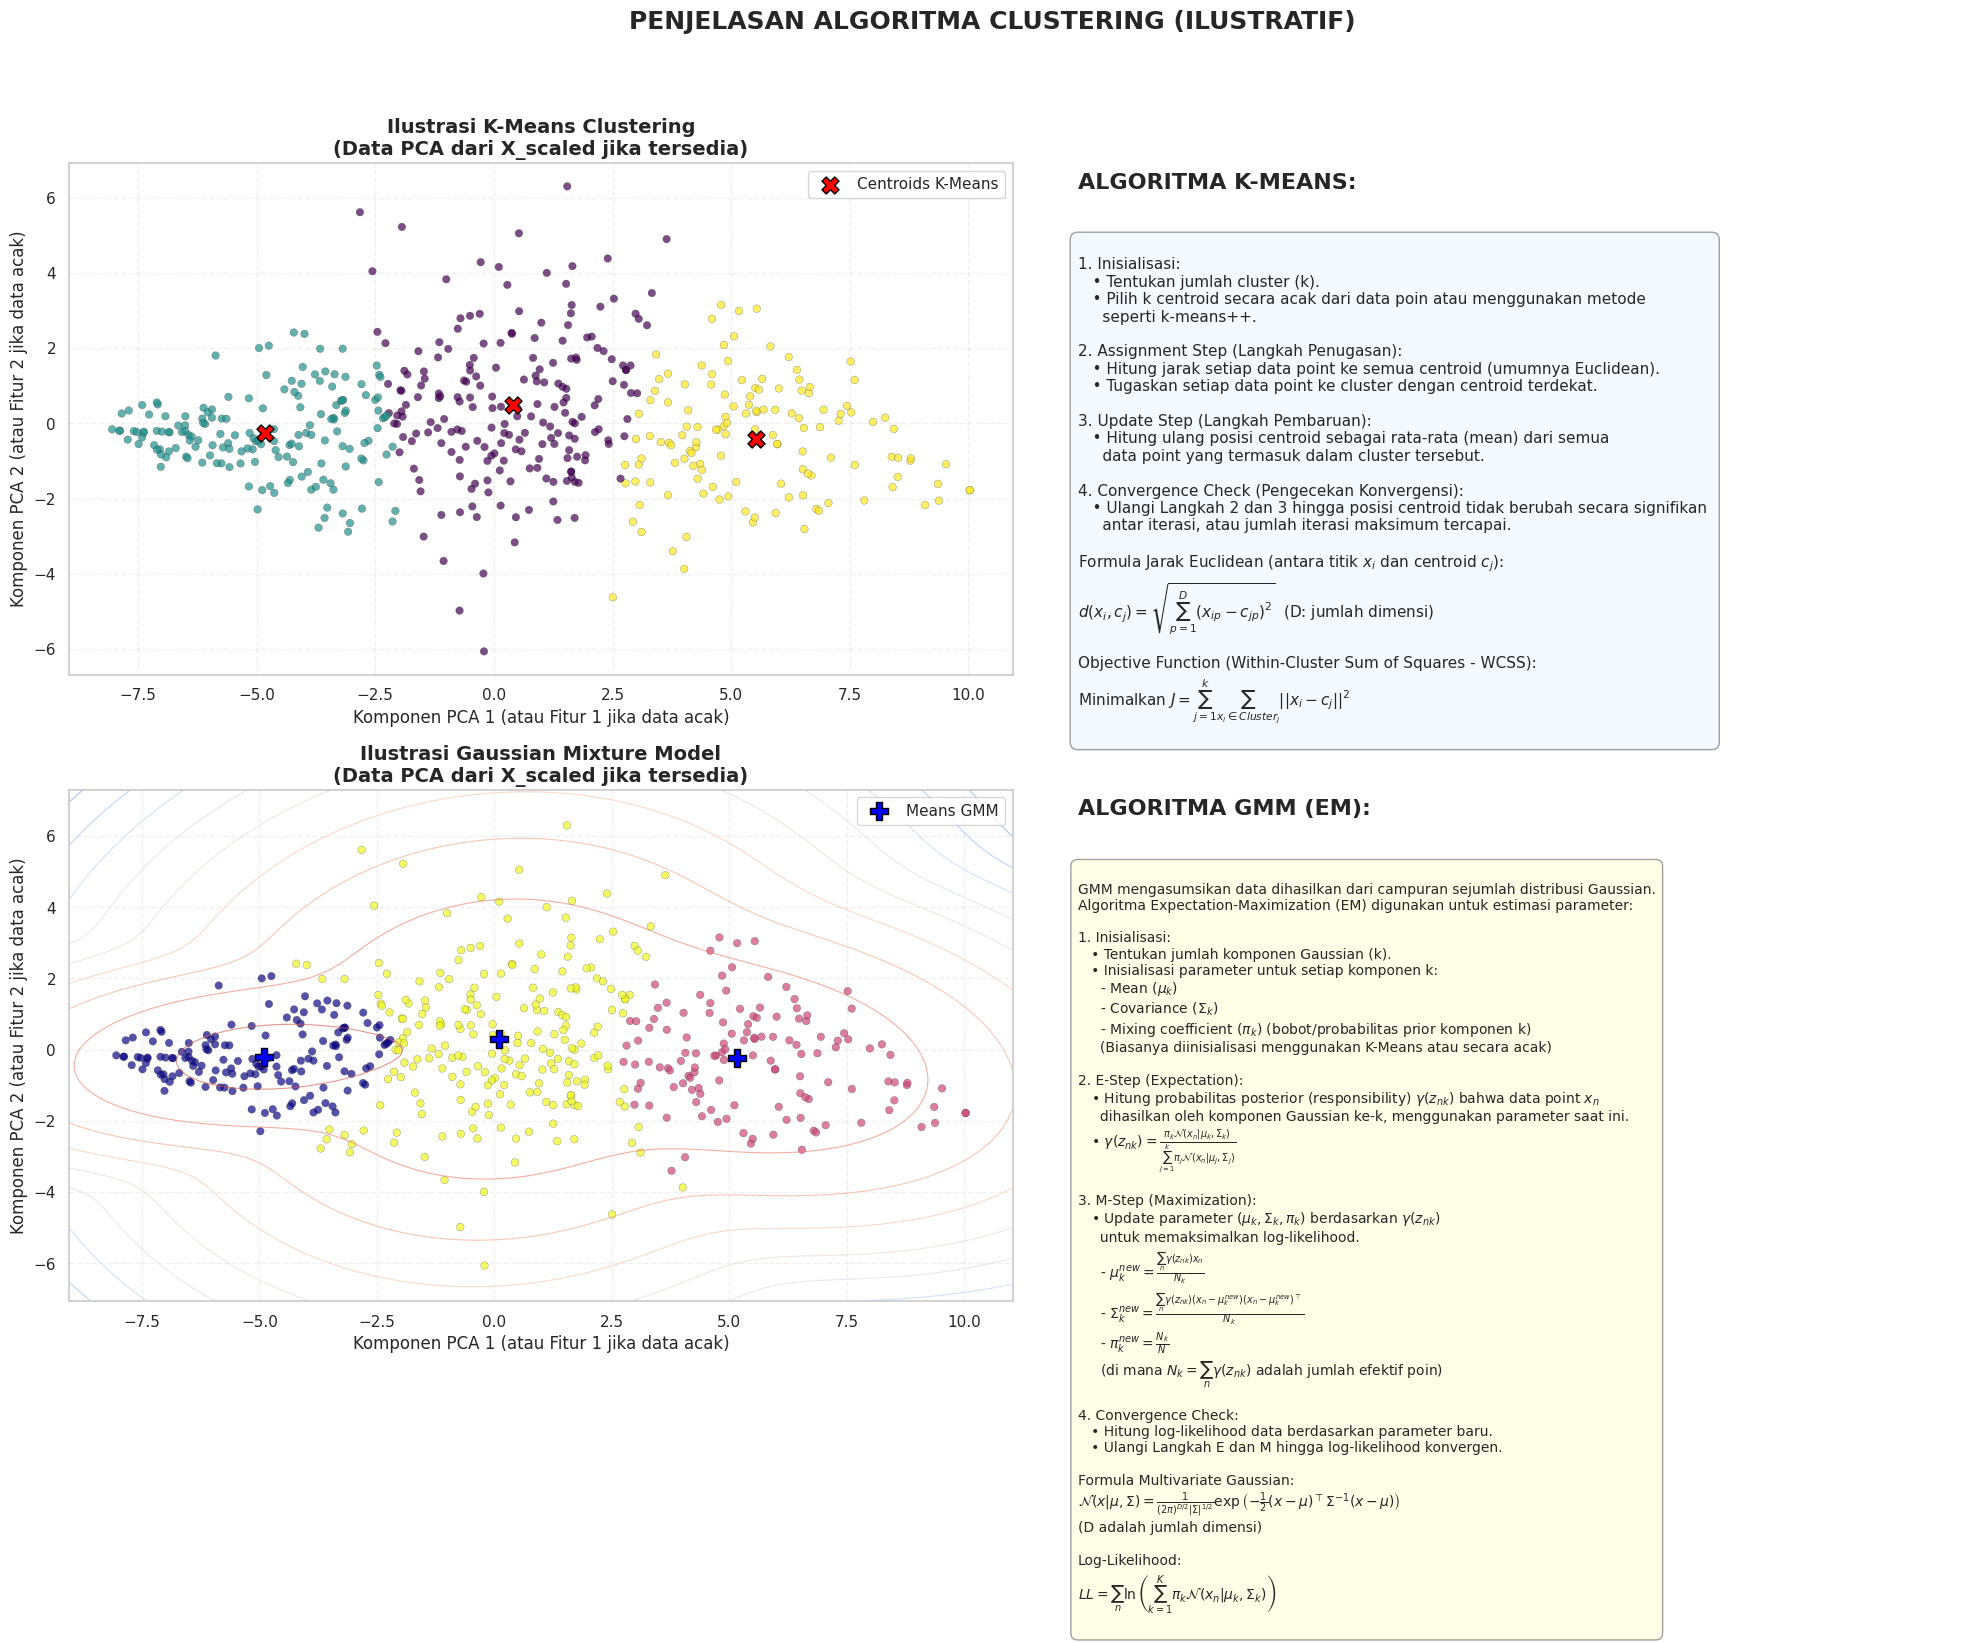

In [ ]:
# ============================================================================
# 4. CLUSTERING ALGORITHMS EXPLANATION
# ============================================================================

print("\n4. PENJELASAN ALGORITMA CLUSTERING")

def plot_algorithm_explanation():
    """Visualisasi penjelasan algoritma K-Means dan GMM menggunakan data PCA dari X_scaled"""
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))

    sample_data_for_plot = None # Inisialisasi

    # Menggunakan data aktual (X_scaled) yang direduksi dimensinya dengan PCA untuk visualisasi
    # Cek apakah X_scaled sudah didefinisikan (dari sel sebelumnya di notebook Anda)
    if 'X_scaled' in globals() and X_scaled is not None and X_scaled.shape[0] > 0:
        print("Menggunakan data X_scaled yang direduksi dengan PCA untuk visualisasi penjelasan algoritma.")
        # Ambil sampel jika data terlalu besar untuk visualisasi penjelasan agar plot tidak terlalu padat
        # Misalnya, ambil maksimal 500 sampel acak jika X_scaled lebih besar dari itu
        num_samples_for_viz = min(X_scaled.shape[0], 500)
        if X_scaled.shape[0] > num_samples_for_viz:
            sample_indices = np.random.choice(X_scaled.shape[0], num_samples_for_viz, replace=False)
            data_to_pca = X_scaled[sample_indices]
        else:
            data_to_pca = X_scaled

        if data_to_pca.shape[1] >= 2: # Pastikan ada setidaknya 2 fitur untuk PCA
            pca_explainer = PCA(n_components=2, random_state=42)
            sample_data_for_plot = pca_explainer.fit_transform(data_to_pca)
            print(f"Data PCA (shape: {sample_data_for_plot.shape}) akan digunakan untuk plot penjelasan.")
        else:
            print("X_scaled memiliki kurang dari 2 fitur, tidak dapat menerapkan PCA untuk visualisasi 2D.")
            # Fallback jika PCA tidak bisa diterapkan (misalnya, X_scaled hanya 1D)
            # Anda bisa membuat data dummy 2D di sini atau skip plot jika tidak relevan
            if data_to_pca.shape[1] == 1: # Jika hanya 1D, buat dimensi kedua dengan random noise kecil
                 sample_data_for_plot = np.hstack((data_to_pca, np.random.normal(0, 0.1, data_to_pca.shape)))
            else: # Jika 0 fitur atau kasus lain
                 sample_data_for_plot = None


    # Jika sample_data_for_plot masih None (misalnya X_scaled tidak ada atau PCA gagal), generate data dummy
    if sample_data_for_plot is None:
        print("X_scaled tidak tersedia atau tidak cocok untuk PCA 2D. Menggunakan data sampel acak untuk visualisasi penjelasan.")
        np.random.seed(42)
        cluster1_dummy = np.random.multivariate_normal([2, 2], [[0.7, 0.1], [0.1, 0.7]], 80)
        cluster2_dummy = np.random.multivariate_normal([5, 5], [[0.9, -0.2], [-0.2, 0.9]], 100)
        cluster3_dummy = np.random.multivariate_normal([3, 6], [[0.6, 0.3], [0.3, 0.6]], 70)
        sample_data_for_plot = np.vstack([cluster1_dummy, cluster2_dummy, cluster3_dummy])

    # --- K-Means Explanation using sample_data_for_plot ---
    # Menggunakan 3 cluster untuk tujuan ilustrasi, ini mungkin berbeda dari OPTIMAL_K Anda
    n_clusters_explanation = 3
    kmeans_sample = KMeans(n_clusters=n_clusters_explanation, random_state=42, n_init='auto')
    kmeans_labels = kmeans_sample.fit_predict(sample_data_for_plot)
    centroids = kmeans_sample.cluster_centers_

    # Plot 1: K-Means Results
    axes[0,0].scatter(sample_data_for_plot[:, 0], sample_data_for_plot[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7, s=30, edgecolor='k', linewidth=0.2)
    axes[0,0].scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X', s=150, linewidths=1, edgecolor='black', label='Centroids K-Means')
    axes[0,0].set_title('Ilustrasi K-Means Clustering\n(Data PCA dari X_scaled jika tersedia)', fontsize=14, fontweight='bold')
    axes[0,0].set_xlabel("Komponen PCA 1 (atau Fitur 1 jika data acak)")
    axes[0,0].set_ylabel("Komponen PCA 2 (atau Fitur 2 jika data acak)")
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3, linestyle='--')

    # Plot 2: K-Means Algorithm Flow (Teks penjelasan tetap sama)
    axes[0,1].text(0.05, 0.95, "ALGORITMA K-MEANS:", fontsize=16, fontweight='bold', transform=axes[0,1].transAxes)
    algorithm_text_kmeans = """
1. Inisialisasi:
   • Tentukan jumlah cluster (k).
   • Pilih k centroid secara acak dari data poin atau menggunakan metode
     seperti k-means++.

2. Assignment Step (Langkah Penugasan):
   • Hitung jarak setiap data point ke semua centroid (umumnya Euclidean).
   • Tugaskan setiap data point ke cluster dengan centroid terdekat.

3. Update Step (Langkah Pembaruan):
   • Hitung ulang posisi centroid sebagai rata-rata (mean) dari semua
     data point yang termasuk dalam cluster tersebut.

4. Convergence Check (Pengecekan Konvergensi):
   • Ulangi Langkah 2 dan 3 hingga posisi centroid tidak berubah secara signifikan
     antar iterasi, atau jumlah iterasi maksimum tercapai.

Formula Jarak Euclidean (antara titik $x_i$ dan centroid $c_j$):
$d(x_i, c_j) = \\sqrt{\\sum_{p=1}^{D}(x_{ip} - c_{jp})^2}$  (D: jumlah dimensi)

Objective Function (Within-Cluster Sum of Squares - WCSS):
Minimalkan $J = \\sum_{j=1}^{k} \\sum_{x_i \\in Cluster_j} ||x_i - c_j||^2$
"""
    axes[0,1].text(0.05, 0.85, algorithm_text_kmeans, fontsize=11, transform=axes[0,1].transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='aliceblue', alpha=0.75, edgecolor='grey'))
    axes[0,1].axis('off')

    # --- GMM Explanation using sample_data_for_plot ---
    gmm_sample = GaussianMixture(n_components=n_clusters_explanation, random_state=42, covariance_type='full', n_init=5)
    gmm_sample.fit(sample_data_for_plot) # Fit GMM
    gmm_labels = gmm_sample.predict(sample_data_for_plot) # Dapatkan label prediksi

    # Plot 3: GMM Results with probability contours
    axes[1,0].scatter(sample_data_for_plot[:, 0], sample_data_for_plot[:, 1], c=gmm_labels, cmap='plasma', alpha=0.7, s=30, edgecolor='k', linewidth=0.2)

    # Add probability contours (ellipses for GMM)
    x_min, x_max = sample_data_for_plot[:, 0].min() - 1, sample_data_for_plot[:, 0].max() + 1
    y_min, y_max = sample_data_for_plot[:, 1].min() - 1, sample_data_for_plot[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 80), np.linspace(y_min, y_max, 80)) # Grid lebih kecil untuk performa
    mesh_points = np.c_[xx.ravel(), yy.ravel()]

    # Plot decision boundary atau log-likelihood contours
    log_prob_mesh = gmm_sample.score_samples(mesh_points) # Log likelihood per sampel
    log_prob_mesh = log_prob_mesh.reshape(xx.shape)

    contour = axes[1,0].contour(xx, yy, log_prob_mesh, levels=10, cmap='coolwarm', alpha=0.6, linewidths=0.8)
    # axes[1,0].clabel(contour, inline=True, fontsize=7, fmt='%1.1f') # Label kontur bisa jadi terlalu ramai

    # Plot means dari GMM
    gmm_means = gmm_sample.means_
    axes[1,0].scatter(gmm_means[:, 0], gmm_means[:, 1], c='blue', marker='P', s=150, edgecolor='black', label='Means GMM')

    axes[1,0].set_title('Ilustrasi Gaussian Mixture Model\n(Data PCA dari X_scaled jika tersedia)', fontsize=14, fontweight='bold')
    axes[1,0].set_xlabel("Komponen PCA 1 (atau Fitur 1 jika data acak)")
    axes[1,0].set_ylabel("Komponen PCA 2 (atau Fitur 2 jika data acak)")
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3, linestyle='--')

    # Plot 4: GMM Algorithm Flow (Teks penjelasan tetap sama)
    axes[1,1].text(0.05, 0.95, "ALGORITMA GMM (EM):", fontsize=16, fontweight='bold', transform=axes[1,1].transAxes)
    gmm_text = """
GMM mengasumsikan data dihasilkan dari campuran sejumlah distribusi Gaussian.
Algoritma Expectation-Maximization (EM) digunakan untuk estimasi parameter:

1. Inisialisasi:
   • Tentukan jumlah komponen Gaussian (k).
   • Inisialisasi parameter untuk setiap komponen k:
     - Mean ($\\mu_k$)
     - Covariance ($\\Sigma_k$)
     - Mixing coefficient ($\\pi_k$) (bobot/probabilitas prior komponen k)
     (Biasanya diinisialisasi menggunakan K-Means atau secara acak)

2. E-Step (Expectation):
   • Hitung probabilitas posterior (responsibility) $\\gamma(z_{nk})$ bahwa data point $x_n$
     dihasilkan oleh komponen Gaussian ke-k, menggunakan parameter saat ini.
   • $\\gamma(z_{nk}) = \\frac{\\pi_k \\mathcal{N}(x_n|\\mu_k, \\Sigma_k)}{\\sum_{j=1}^{k} \\pi_j \\mathcal{N}(x_n|\\mu_j, \\Sigma_j)}$

3. M-Step (Maximization):
   • Update parameter ($\\mu_k, \\Sigma_k, \\pi_k$) berdasarkan $\\gamma(z_{nk})$
     untuk memaksimalkan log-likelihood.
     - $\\mu_k^{new} = \\frac{\\sum_n \\gamma(z_{nk})x_n}{N_k}$
     - $\\Sigma_k^{new} = \\frac{\\sum_n \\gamma(z_{nk})(x_n-\\mu_k^{new})(x_n-\\mu_k^{new})^\\top}{N_k}$
     - $\\pi_k^{new} = \\frac{N_k}{N}$
     (di mana $N_k = \\sum_n \\gamma(z_{nk})$ adalah jumlah efektif poin)

4. Convergence Check:
   • Hitung log-likelihood data berdasarkan parameter baru.
   • Ulangi Langkah E dan M hingga log-likelihood konvergen.

Formula Multivariate Gaussian:
$\\mathcal{N}(x|\\mu,\\Sigma) = \\frac{1}{(2\\pi)^{D/2}|\\Sigma|^{1/2}} \\exp\\left(-\\frac{1}{2}(x-\\mu)^\\top\\Sigma^{-1}(x-\\mu)\\right)$
(D adalah jumlah dimensi)

Log-Likelihood:
$LL = \\sum_n \\ln\\left(\\sum_{k=1}^{K} \\pi_k \\mathcal{N}(x_n|\\mu_k,\\Sigma_k)\\right)$
"""
    axes[1,1].text(0.05, 0.85, gmm_text, fontsize=10, transform=axes[1,1].transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', fc='lightyellow', alpha=0.75, edgecolor='grey'))
    axes[1,1].axis('off')

    plt.suptitle('PENJELASAN ALGORITMA CLUSTERING (ILUSTRATIF)', fontsize=18, fontweight='bold', y=1.0) # Sedikit turunkan suptitle
    plt.tight_layout(rect=[0, 0, 1, 0.97]) # Adjust layout untuk suptitle
    plt.show()

# Panggil fungsi untuk menampilkan plot penjelasan
# Pastikan variabel X_scaled sudah ada dan terisi dari langkah sebelumnya di notebook Anda
if 'X_scaled' in globals() and X_scaled is not None:
    plot_algorithm_explanation()
else:
    # Jika X_scaled belum ada, Anda mungkin perlu menjalankannya dulu atau menyediakan data dummy
    print("Variabel X_scaled tidak ditemukan. Menjalankan plot_algorithm_explanation() dengan data acak internal.")
    # Untuk menjalankan dengan data acak jika X_scaled tidak ada, Anda bisa memodifikasi fungsi atau
    # membuat X_scaled dummy di sini sebelum memanggil fungsi.
    # Contoh: X_scaled = np.random.rand(100, 5) # Dummy X_scaled jika tidak ada
    plot_algorithm_explanation() # Fungsi akan menggunakan data acak internal jika X_scaled tidak valid

### 5. Penentuan Jumlah Cluster Optimal

Mencari jumlah cluster (k) yang optimal menggunakan berbagai metrik evaluasi seperti Elbow Method (Inertia), Silhouette Score, Davies-Bouldin Index, Calinski-Harabasz Index, serta BIC dan AIC untuk GMM. Hasil evaluasi divisualisasikan untuk membantu pengambilan keputusan.


5. PENCARIAN JUMLAH CLUSTER OPTIMAL & COVARIANCE TYPE GMM...

--- Mengevaluasi K-Means ---
  K-Means k=2: Inertia=994761, Silhouette=0.263
  K-Means k=3: Inertia=890139, Silhouette=0.171
  K-Means k=4: Inertia=847486, Silhouette=0.126
  K-Means k=5: Inertia=814865, Silhouette=0.115
  K-Means k=6: Inertia=793871, Silhouette=0.095
  K-Means k=7: Inertia=780318, Silhouette=0.083
  K-Means k=8: Inertia=769710, Silhouette=0.071
  K-Means k=9: Inertia=760489, Silhouette=0.072
  K-Means k=10: Inertia=753079, Silhouette=0.069


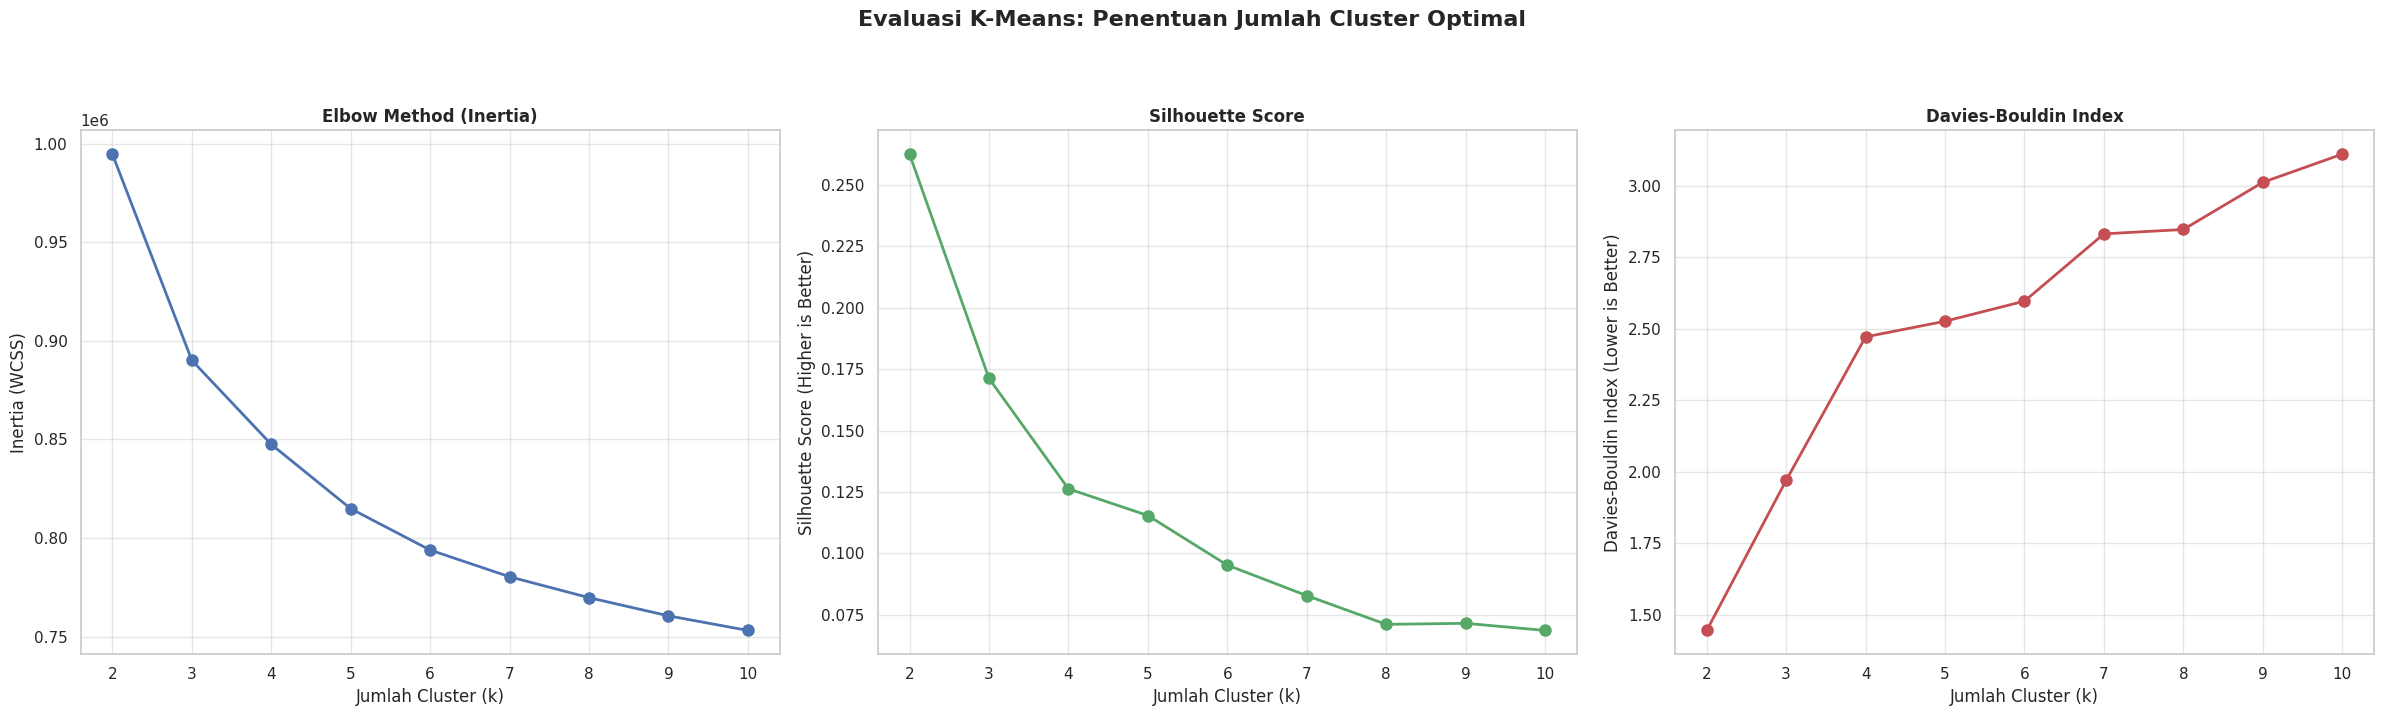


--- Mengevaluasi GMM (dengan berbagai covariance_type) ---

  Mengevaluasi GMM dengan covariance_type = 'spherical'
    k=2: BIC=3595619, AIC=3594884, Silhouette=0.252
    k=3: BIC=3430547, AIC=3429440, Silhouette=0.158
    k=4: BIC=3354369, AIC=3352890, Silhouette=0.091
    k=5: BIC=3318923, AIC=3317072, Silhouette=0.096
    k=6: BIC=3279999, AIC=3277776, Silhouette=0.058
    k=7: BIC=3255527, AIC=3252932, Silhouette=0.025
    k=8: BIC=3239538, AIC=3236571, Silhouette=0.017
    k=9: BIC=3225330, AIC=3221992, Silhouette=0.005
    k=10: BIC=3214700, AIC=3210990, Silhouette=-0.004

  Mengevaluasi GMM dengan covariance_type = 'diag'
    k=2: BIC=3567101, AIC=3565673, Silhouette=0.254
    k=3: BIC=3379909, AIC=3377762, Silhouette=0.156
    k=4: BIC=3165596, AIC=3162731, Silhouette=0.093
    k=5: BIC=3024537, AIC=3020954, Silhouette=0.043
    k=6: BIC=2948745, AIC=2944444, Silhouette=0.023
    k=7: BIC=2810974, AIC=2805954, Silhouette=0.010
    k=8: BIC=2748618, AIC=2742880, Silhouette=0.0

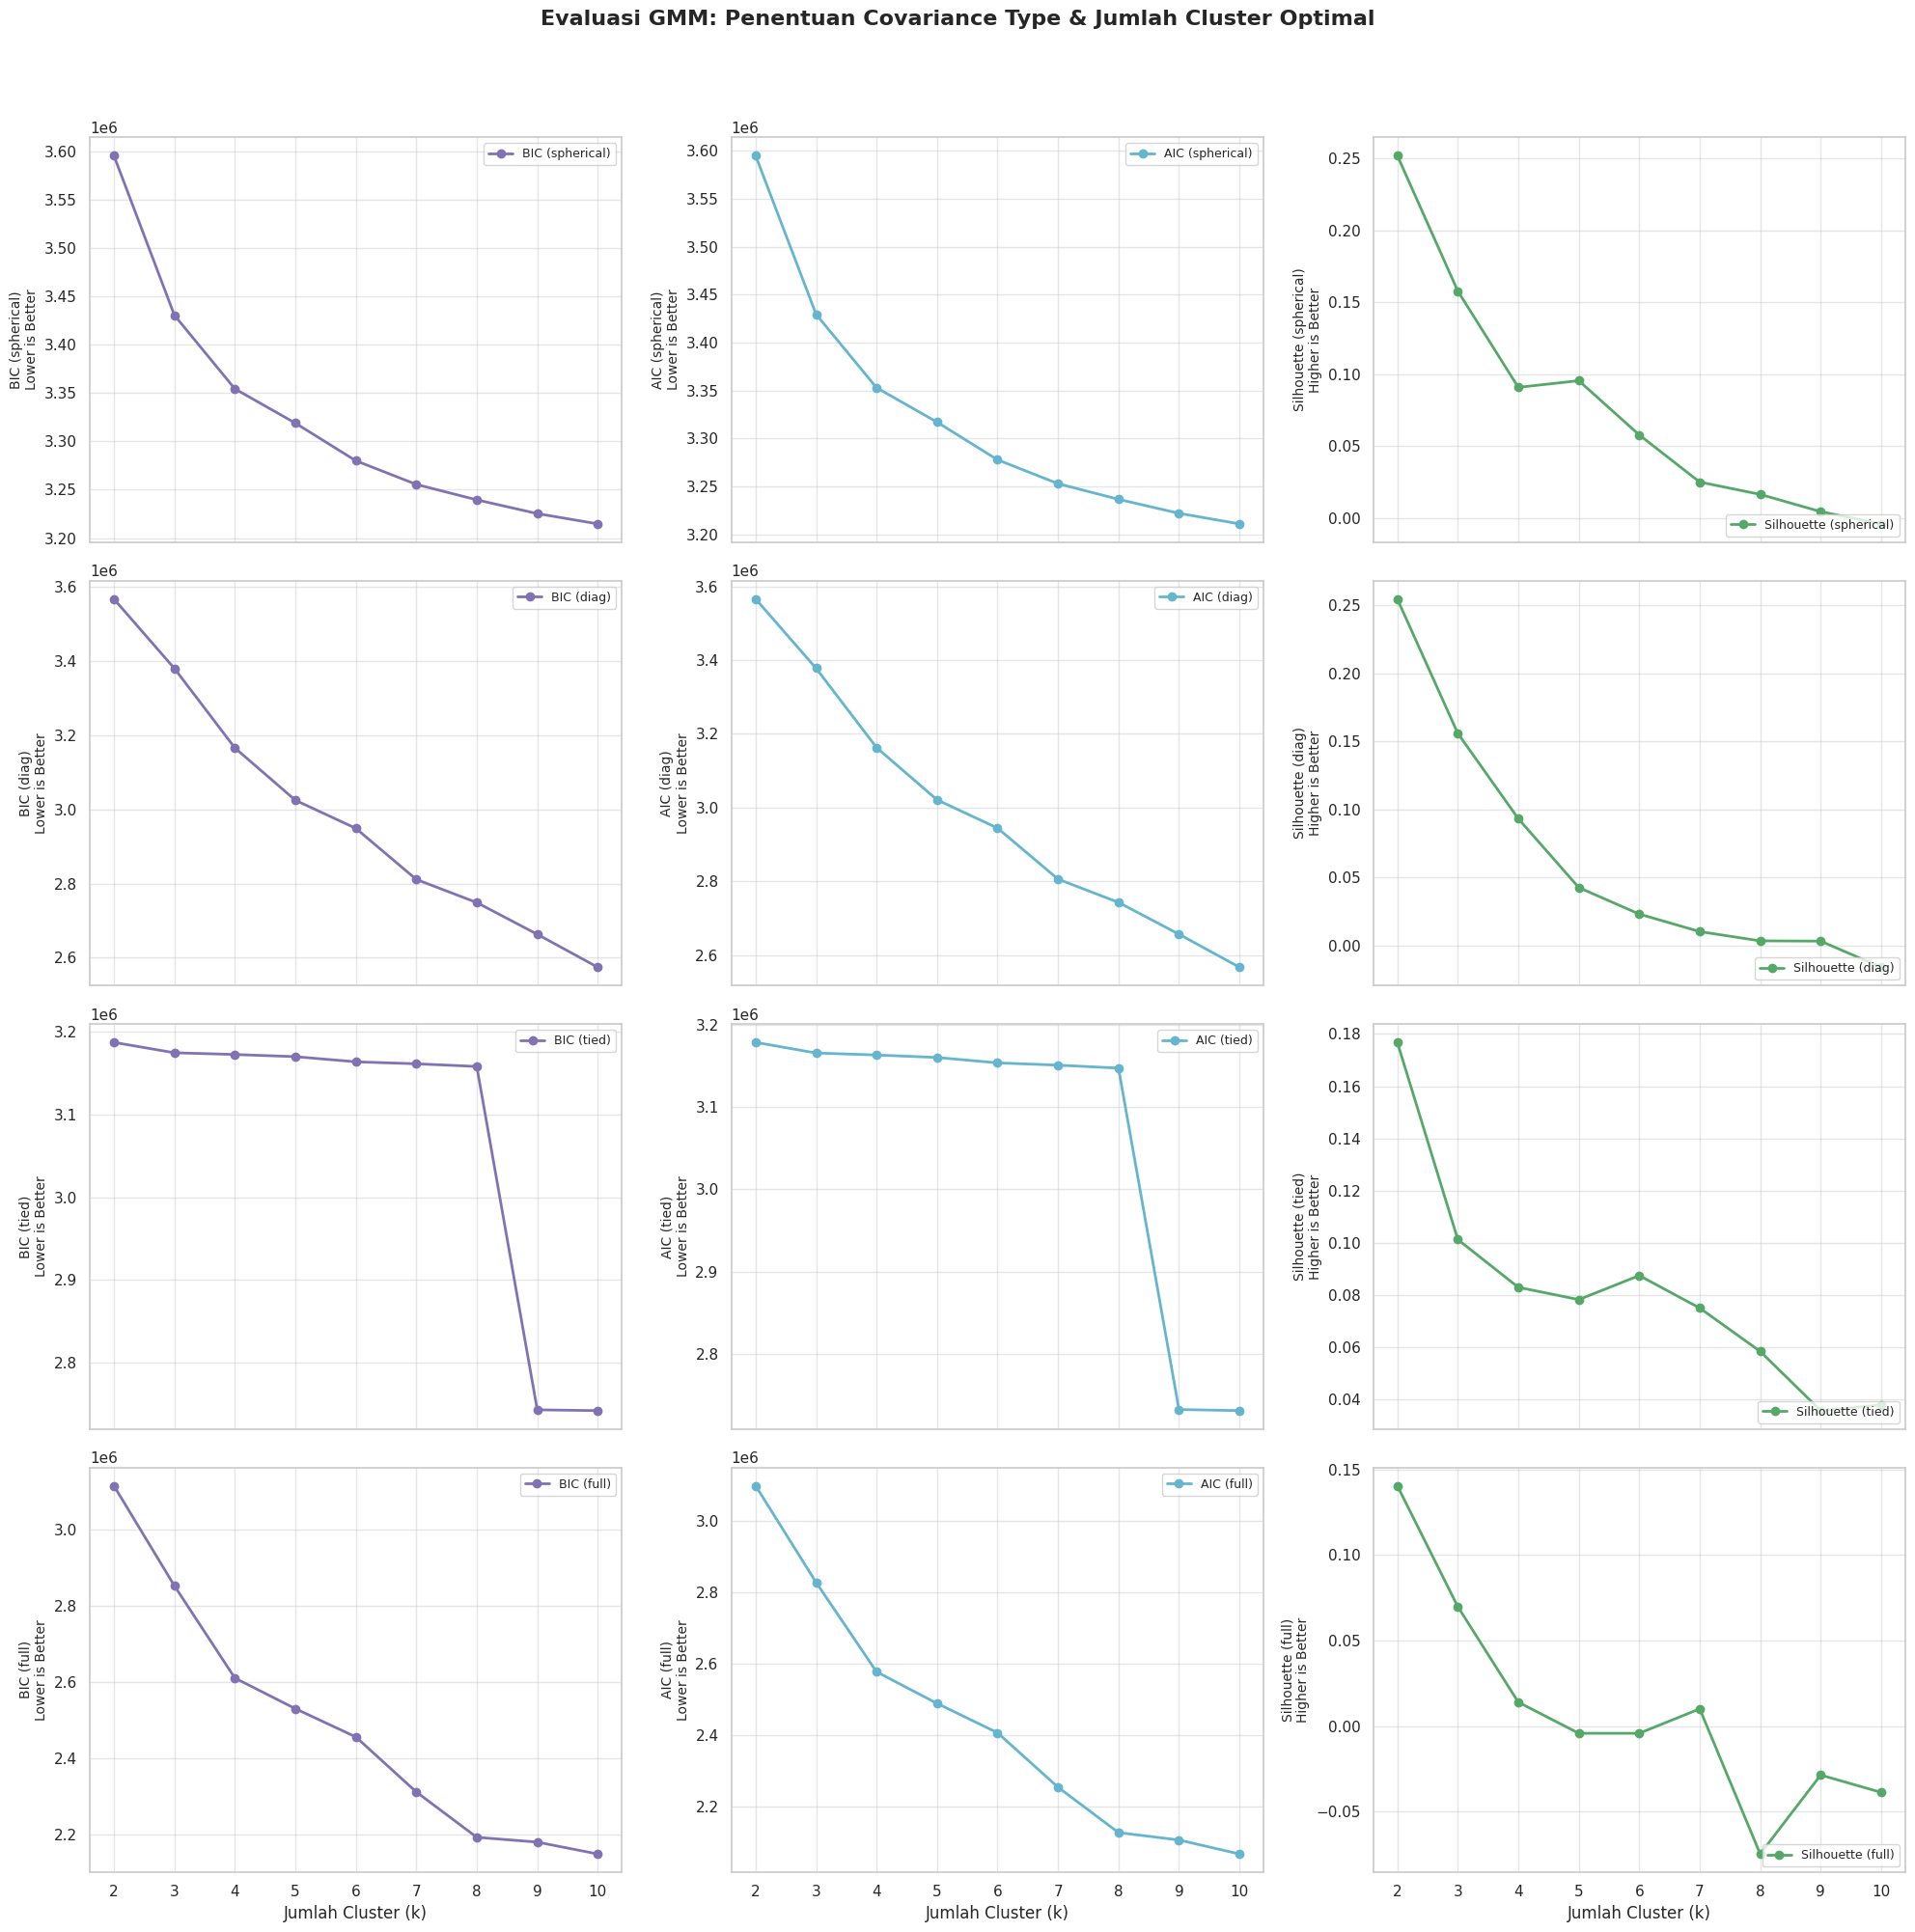


K Optimal untuk K-Means (Silhouette tertinggi): 2 (Silhouette: 0.263)

Mencari Covariance Type Terbaik dan K Optimal untuk GMM (berdasarkan BIC terendah):
  Covariance Type 'spherical': Min BIC = 3214700 pada k = 10
  Covariance Type 'diag': Min BIC = 2574200 pada k = 10
  Covariance Type 'tied': Min BIC = 2742630 pada k = 10
  Covariance Type 'full': Min BIC = 2148077 pada k = 10

Covariance Type Terbaik untuk GMM: 'full'
K Optimal untuk GMM (BIC terendah dengan 'full'): 10 (BIC: 2148077)
  Silhouette Score GMM pada k=10, cov='full': -0.039

K Fixed yang akan digunakan (ditentukan pengguna/default): 4
CATATAN: Harap perbarui nilai 'K_FIXED_USER_DEFINED' di atas kode ini setelah Anda
menganalisis plot evaluasi untuk K-Means dan GMM (terutama Silhouette & Davies-Bouldin).
Pilih nilai 'k' yang menunjukkan performa yang masuk akal untuk KEDUA algoritma.


In [ ]:
K_RANGE_EVAL = range(2, 11) # Evaluasi dari 2 hingga 10 cluster
evaluation_results_kmeans = {}
evaluation_results_gmm = {} # Akan berisi hasil untuk berbagai covariance_type

if X_scaled is not None:
    print("\n5. PENCARIAN JUMLAH CLUSTER OPTIMAL & COVARIANCE TYPE GMM...")

    # --- K-Means Evaluation ---
    print("\n--- Mengevaluasi K-Means ---")
    inertia_scores = []
    silhouette_scores_kmeans = []
    davies_bouldin_scores_kmeans = []
    calinski_harabasz_scores_kmeans = []

    for k_val in K_RANGE_EVAL:
        kmeans = KMeans(n_clusters=k_val, random_state=42, n_init=30, init='k-means++') # Peningkatan n_init
        kmeans_labels = kmeans.fit_predict(X_scaled)

        inertia_scores.append(kmeans.inertia_)
        if len(np.unique(kmeans_labels)) > 1:
            silhouette_scores_kmeans.append(silhouette_score(X_scaled, kmeans_labels))
            davies_bouldin_scores_kmeans.append(davies_bouldin_score(X_scaled, kmeans_labels))
            calinski_harabasz_scores_kmeans.append(calinski_harabasz_score(X_scaled, kmeans_labels))
        else:
            silhouette_scores_kmeans.append(-1) # Placeholder
            davies_bouldin_scores_kmeans.append(np.nan)
            calinski_harabasz_scores_kmeans.append(np.nan)
        print(f"  K-Means k={k_val}: Inertia={kmeans.inertia_:.0f}, Silhouette={silhouette_scores_kmeans[-1]:.3f}")

    evaluation_results_kmeans = {
        'k_range': list(K_RANGE_EVAL), 'inertia': inertia_scores,
        'silhouette': silhouette_scores_kmeans, 'davies_bouldin': davies_bouldin_scores_kmeans,
        'calinski_harabasz': calinski_harabasz_scores_kmeans
    }

    # Plotting K-Means evaluation
    fig_kmeans_eval, axes_kmeans_eval = plt.subplots(1, 3, figsize=(24, 7)) # Adjusted for 3 plots
    fig_kmeans_eval.suptitle('Evaluasi K-Means: Penentuan Jumlah Cluster Optimal', fontsize=16, fontweight='bold', y=1.02)

    axes_kmeans_eval[0].plot(K_RANGE_EVAL, inertia_scores, 'bo-', linewidth=2, markersize=8)
    axes_kmeans_eval[0].set_title('Elbow Method (Inertia)', fontweight='bold')
    axes_kmeans_eval[0].set_xlabel('Jumlah Cluster (k)')
    axes_kmeans_eval[0].set_ylabel('Inertia (WCSS)')

    axes_kmeans_eval[1].plot(K_RANGE_EVAL, silhouette_scores_kmeans, 'go-', linewidth=2, markersize=8)
    axes_kmeans_eval[1].set_title('Silhouette Score', fontweight='bold')
    axes_kmeans_eval[1].set_xlabel('Jumlah Cluster (k)')
    axes_kmeans_eval[1].set_ylabel('Silhouette Score (Higher is Better)')

    axes_kmeans_eval[2].plot(K_RANGE_EVAL, davies_bouldin_scores_kmeans, 'ro-', linewidth=2, markersize=8)
    axes_kmeans_eval[2].set_title('Davies-Bouldin Index', fontweight='bold')
    axes_kmeans_eval[2].set_xlabel('Jumlah Cluster (k)')
    axes_kmeans_eval[2].set_ylabel('Davies-Bouldin Index (Lower is Better)')

    for ax in axes_kmeans_eval:
        ax.grid(True, alpha=0.5)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # --- GMM Evaluation (termasuk covariance_type) ---
    print("\n--- Mengevaluasi GMM (dengan berbagai covariance_type) ---")
    COVARIANCE_TYPES = ['spherical', 'diag', 'tied', 'full']

    for cov_type in COVARIANCE_TYPES:
        print(f"\n  Mengevaluasi GMM dengan covariance_type = '{cov_type}'")
        bic_scores_gmm = []
        aic_scores_gmm = []
        silhouette_scores_gmm_cov = []
        davies_bouldin_scores_gmm_cov = []
        calinski_harabasz_scores_gmm_cov = []

        for k_val in K_RANGE_EVAL:
            try:
                gmm = GaussianMixture(n_components=k_val, random_state=42, covariance_type=cov_type,
                                      n_init=20, init_params='kmeans', reg_covar=1e-6) # Peningkatan n_init
                gmm.fit(X_scaled)
                gmm_labels = gmm.predict(X_scaled)

                bic_scores_gmm.append(gmm.bic(X_scaled))
                aic_scores_gmm.append(gmm.aic(X_scaled))
                if len(np.unique(gmm_labels)) > 1:
                    silhouette_scores_gmm_cov.append(silhouette_score(X_scaled, gmm_labels))
                    davies_bouldin_scores_gmm_cov.append(davies_bouldin_score(X_scaled, gmm_labels))
                    calinski_harabasz_scores_gmm_cov.append(calinski_harabasz_score(X_scaled, gmm_labels))
                else:
                    silhouette_scores_gmm_cov.append(-1) # Placeholder
                    davies_bouldin_scores_gmm_cov.append(np.nan)
                    calinski_harabasz_scores_gmm_cov.append(np.nan)
                print(f"    k={k_val}: BIC={bic_scores_gmm[-1]:.0f}, AIC={aic_scores_gmm[-1]:.0f}, Silhouette={silhouette_scores_gmm_cov[-1]:.3f}")
            except Exception as e_gmm_eval:
                print(f"    Error GMM k={k_val}, cov_type='{cov_type}': {e_gmm_eval}")
                bic_scores_gmm.append(np.nan)
                aic_scores_gmm.append(np.nan)
                silhouette_scores_gmm_cov.append(np.nan)
                davies_bouldin_scores_gmm_cov.append(np.nan)
                calinski_harabasz_scores_gmm_cov.append(np.nan)

        evaluation_results_gmm[cov_type] = {
            'k_range': list(K_RANGE_EVAL), 'bic': bic_scores_gmm, 'aic': aic_scores_gmm,
            'silhouette': silhouette_scores_gmm_cov, 'davies_bouldin': davies_bouldin_scores_gmm_cov,
            'calinski_harabasz': calinski_harabasz_scores_gmm_cov
        }

    # Plotting GMM evaluation (BIC, AIC, Silhouette per covariance_type)
    num_metrics_gmm = 3 # BIC, AIC, Silhouette
    fig_gmm_eval, axes_gmm_eval = plt.subplots(len(COVARIANCE_TYPES), num_metrics_gmm,
                                               figsize=(20, 5 * len(COVARIANCE_TYPES)),
                                               sharex='col') # share x-axis (k_range)
    fig_gmm_eval.suptitle('Evaluasi GMM: Penentuan Covariance Type & Jumlah Cluster Optimal', fontsize=16, fontweight='bold', y=1.0)

    for i, cov_type in enumerate(COVARIANCE_TYPES):
        res_gmm = evaluation_results_gmm[cov_type]

        # BIC
        ax_bic = axes_gmm_eval[i, 0]
        ax_bic.plot(res_gmm['k_range'], res_gmm['bic'], 'mo-', label=f'BIC ({cov_type})', linewidth=2, markersize=6)
        ax_bic.set_ylabel(f'BIC ({cov_type})\nLower is Better', fontsize=10)
        ax_bic.legend(loc='upper right', fontsize=9)
        if i == len(COVARIANCE_TYPES) - 1 : ax_bic.set_xlabel('Jumlah Cluster (k)')

        # AIC
        ax_aic = axes_gmm_eval[i, 1]
        ax_aic.plot(res_gmm['k_range'], res_gmm['aic'], 'co-', label=f'AIC ({cov_type})', linewidth=2, markersize=6)
        ax_aic.set_ylabel(f'AIC ({cov_type})\nLower is Better', fontsize=10)
        ax_aic.legend(loc='upper right', fontsize=9)
        if i == len(COVARIANCE_TYPES) - 1 : ax_aic.set_xlabel('Jumlah Cluster (k)')

        # Silhouette
        ax_sil_gmm = axes_gmm_eval[i, 2]
        ax_sil_gmm.plot(res_gmm['k_range'], res_gmm['silhouette'], 'go-', label=f'Silhouette ({cov_type})', linewidth=2, markersize=6)
        ax_sil_gmm.set_ylabel(f'Silhouette ({cov_type})\nHigher is Better', fontsize=10)
        ax_sil_gmm.legend(loc='lower right', fontsize=9)
        if i == len(COVARIANCE_TYPES) - 1 : ax_sil_gmm.set_xlabel('Jumlah Cluster (k)')

        for ax_row_idx in range(num_metrics_gmm):
            axes_gmm_eval[i, ax_row_idx].grid(True, alpha=0.5)
            axes_gmm_eval[i, ax_row_idx].set_xticks(list(K_RANGE_EVAL))


    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

    # --- Penentuan k_optimal dan best_covariance_type ---
    # K-Means Optimal k (berdasarkan Silhouette tertinggi)
    k_optimal_kmeans_idx = np.nanargmax(evaluation_results_kmeans['silhouette'])
    K_OPTIMAL_KMEANS = evaluation_results_kmeans['k_range'][k_optimal_kmeans_idx]
    print(f"\nK Optimal untuk K-Means (Silhouette tertinggi): {K_OPTIMAL_KMEANS} (Silhouette: {evaluation_results_kmeans['silhouette'][k_optimal_kmeans_idx]:.3f})")

    # GMM Best Covariance Type & Optimal k (berdasarkan BIC terendah)
    best_bic_overall = np.inf
    BEST_COVARIANCE_TYPE_GMM = None
    K_OPTIMAL_GMM = None

    print("\nMencari Covariance Type Terbaik dan K Optimal untuk GMM (berdasarkan BIC terendah):")
    for cov_type in COVARIANCE_TYPES:
        bics = evaluation_results_gmm[cov_type]['bic']
        k_range_gmm = evaluation_results_gmm[cov_type]['k_range']

        # Hindari NaN dalam pencarian min BIC
        valid_bics_indices = ~np.isnan(bics)
        if np.any(valid_bics_indices):
            min_bic_for_cov = np.nanmin(bics)
            k_for_min_bic_idx = np.nanargmin(bics)
            k_for_min_bic = k_range_gmm[k_for_min_bic_idx]
            print(f"  Covariance Type '{cov_type}': Min BIC = {min_bic_for_cov:.0f} pada k = {k_for_min_bic}")
            if min_bic_for_cov < best_bic_overall:
                best_bic_overall = min_bic_for_cov
                BEST_COVARIANCE_TYPE_GMM = cov_type
                K_OPTIMAL_GMM = k_for_min_bic
        else:
            print(f"  Covariance Type '{cov_type}': Tidak ada nilai BIC yang valid.")


    if BEST_COVARIANCE_TYPE_GMM and K_OPTIMAL_GMM:
        print(f"\nCovariance Type Terbaik untuk GMM: '{BEST_COVARIANCE_TYPE_GMM}'")
        print(f"K Optimal untuk GMM (BIC terendah dengan '{BEST_COVARIANCE_TYPE_GMM}'): {K_OPTIMAL_GMM} (BIC: {best_bic_overall:.0f})")
        # Tampilkan juga Silhouette score untuk GMM optimal ini
        idx_k_optimal_gmm = evaluation_results_gmm[BEST_COVARIANCE_TYPE_GMM]['k_range'].index(K_OPTIMAL_GMM)
        sil_at_k_optimal_gmm = evaluation_results_gmm[BEST_COVARIANCE_TYPE_GMM]['silhouette'][idx_k_optimal_gmm]
        print(f"  Silhouette Score GMM pada k={K_OPTIMAL_GMM}, cov='{BEST_COVARIANCE_TYPE_GMM}': {sil_at_k_optimal_gmm:.3f}")

    else:
        print("\nTidak dapat menentukan Covariance Type atau K Optimal untuk GMM secara otomatis. Periksa hasil evaluasi.")
        # Fallback jika gagal (misalnya semua NaN)
        BEST_COVARIANCE_TYPE_GMM = 'full' # Default fallback
        K_OPTIMAL_GMM = K_RANGE_EVAL[2] if len(K_RANGE_EVAL) > 2 else K_RANGE_EVAL[0] # Misal k=4 sebagai fallback
        print(f"Menggunakan fallback: Cov_type='{BEST_COVARIANCE_TYPE_GMM}', K_optimal_GMM={K_OPTIMAL_GMM}")


    # !!! TEMPAT UNTUK USER INPUT K_FIXED !!!
    # Berdasarkan plot evaluasi di atas (K-Means dan GMM), tentukan K_FIXED.
    # K_FIXED adalah nilai k yang Anda anggap sebagai kompromi yang baik untuk perbandingan langsung
    # antara K-Means dan GMM pada jumlah cluster yang sama.
    K_FIXED_USER_DEFINED = 4 # GANTI NILAI INI SESUAI ANALISIS ANDA. Misal: 3 atau 4 atau 5.
    print(f"\nK Fixed yang akan digunakan (ditentukan pengguna/default): {K_FIXED_USER_DEFINED}")
    print("="*50)
    print("CATATAN: Harap perbarui nilai 'K_FIXED_USER_DEFINED' di atas kode ini setelah Anda")
    print("menganalisis plot evaluasi untuk K-Means dan GMM (terutama Silhouette & Davies-Bouldin).")
    print("Pilih nilai 'k' yang menunjukkan performa yang masuk akal untuk KEDUA algoritma.")
    print("="*50)


else:
    print("Data X_scaled tidak tersedia, penentuan jumlah cluster optimal dilewati.")
    K_OPTIMAL_KMEANS = 4 # Default jika langkah sebelumnya gagal
    BEST_COVARIANCE_TYPE_GMM = 'full'
    K_OPTIMAL_GMM = 4    # Default
    K_FIXED_USER_DEFINED = 4 # Default
    evaluation_results_kmeans = None
    evaluation_results_gmm = None

### 6. Implementasi Clustering

Semua model menggunakan jumlah cluster optimal yang telah ditentukan sebelumnya.

In [ ]:
kmeans_labels_kfixed, gmm_labels_kfixed = None, None
kmeans_labels_koptimal, gmm_labels_koptimal = None, None

# Model Objects
model_kmeans_kfixed, model_gmm_kfixed = None, None
model_kmeans_koptimal, model_gmm_koptimal = None, None


if X_scaled is not None and K_FIXED_USER_DEFINED and K_OPTIMAL_KMEANS and K_OPTIMAL_GMM and BEST_COVARIANCE_TYPE_GMM:
    print("\n6. IMPLEMENTASI CLUSTERING (4 SKENARIO)...\n")

    # Skenario 1: K-Means dengan k_fixed
    print(f"Skenario 1: K-Means dengan k_fixed = {K_FIXED_USER_DEFINED}")
    model_kmeans_kfixed = KMeans(n_clusters=K_FIXED_USER_DEFINED, random_state=42, n_init=30, init='k-means++')
    kmeans_labels_kfixed = model_kmeans_kfixed.fit_predict(X_scaled)
    print(f"  Label K-Means (k_fixed) dihasilkan. Contoh: {kmeans_labels_kfixed[:10]}\n")

    # Skenario 2: GMM dengan k_fixed dan best_covariance_type
    print(f"Skenario 2: GMM dengan k_fixed = {K_FIXED_USER_DEFINED}, cov_type = '{BEST_COVARIANCE_TYPE_GMM}'")
    model_gmm_kfixed = GaussianMixture(n_components=K_FIXED_USER_DEFINED, random_state=42,
                                       covariance_type=BEST_COVARIANCE_TYPE_GMM, n_init=20, init_params='kmeans', reg_covar=1e-6)
    model_gmm_kfixed.fit(X_scaled)
    gmm_labels_kfixed = model_gmm_kfixed.predict(X_scaled)
    print(f"  Label GMM (k_fixed) dihasilkan. Contoh: {gmm_labels_kfixed[:10]}\n")

    # Skenario 3: K-Means dengan k_optimal_kmeans
    print(f"Skenario 3: K-Means dengan k_optimal_kmeans = {K_OPTIMAL_KMEANS}")
    model_kmeans_koptimal = KMeans(n_clusters=K_OPTIMAL_KMEANS, random_state=42, n_init=30, init='k-means++')
    kmeans_labels_koptimal = model_kmeans_koptimal.fit_predict(X_scaled)
    print(f"  Label K-Means (k_optimal) dihasilkan. Contoh: {kmeans_labels_koptimal[:10]}\n")

    # Skenario 4: GMM dengan k_optimal_gmm dan best_covariance_type
    print(f"Skenario 4: GMM dengan k_optimal_gmm = {K_OPTIMAL_GMM}, cov_type = '{BEST_COVARIANCE_TYPE_GMM}'")
    model_gmm_koptimal = GaussianMixture(n_components=K_OPTIMAL_GMM, random_state=42,
                                        covariance_type=BEST_COVARIANCE_TYPE_GMM, n_init=20, init_params='kmeans', reg_covar=1e-6)
    model_gmm_koptimal.fit(X_scaled)
    gmm_labels_koptimal = model_gmm_koptimal.predict(X_scaled)
    print(f"  Label GMM (k_optimal) dihasilkan. Contoh: {gmm_labels_koptimal[:10]}\n")

    print("\nSemua model clustering berhasil dilatih untuk 4 skenario!")
else:
    print("Data X_scaled atau parameter k optimal/fixed tidak tersedia, implementasi clustering dilewati.")


6. IMPLEMENTASI CLUSTERING (4 SKENARIO)...

Skenario 1: K-Means dengan k_fixed = 4
  Label K-Means (k_fixed) dihasilkan. Contoh: [0 3 3 1 0 2 3 0 1 1]

Skenario 2: GMM dengan k_fixed = 4, cov_type = 'full'
  Label GMM (k_fixed) dihasilkan. Contoh: [2 0 1 0 1 2 2 1 2 0]

Skenario 3: K-Means dengan k_optimal_kmeans = 2
  Label K-Means (k_optimal) dihasilkan. Contoh: [1 1 1 0 1 0 1 1 0 1]

Skenario 4: GMM dengan k_optimal_gmm = 10, cov_type = 'full'
  Label GMM (k_optimal) dihasilkan. Contoh: [9 7 6 7 6 8 2 6 8 8]


Semua model clustering berhasil dilatih untuk 4 skenario!


## Bagian 3: Evaluator dan Visualisasi Hasil

### 7. Metrik Evaluasi Clustering

Menghitung dan menampilkan metrik evaluasi internal untuk setiap skenario clustering. Metrik yang digunakan adalah Silhouette Score, Calinski-Harabasz Index, dan Davies-Bouldin Index. Penjelasan singkat mengenai masing-masing metrik juga disertakan.

In [ ]:
print("7. Metrik Evaluasi Clustering")

eval_metrics = {} # Dictionary untuk menyimpan semua hasil evaluasi

if X_scaled is not None:

    def calculate_evaluation_metrics(X_data_eval, labels_eval, scenario_name_eval):
        metrics = {'scenario': scenario_name_eval}
        print(f"\nEvaluasi untuk: {scenario_name_eval}")
        print(f"  Jumlah data poin: {X_data_eval.shape[0]}, Jumlah label unik: {len(np.unique(labels_eval))}")

        if labels_eval is None or len(np.unique(labels_eval)) < 2 or len(np.unique(labels_eval)) > X_data_eval.shape[0] -1 :
            print("  Tidak dapat menghitung metrik: jumlah label unik tidak valid (<2 atau >N-1) atau label None.")
            metrics['silhouette'] = np.nan
            metrics['calinski_harabasz'] = np.nan
            metrics['davies_bouldin'] = np.nan
            return metrics

        try:
            metrics['silhouette'] = silhouette_score(X_data_eval, labels_eval)
            print(f"  Silhouette Score: {metrics['silhouette']:.4f}")
        except Exception as e_sil: # Lebih umum untuk menangkap berbagai error
            print(f"  Error menghitung Silhouette Score: {e_sil}")
            metrics['silhouette'] = np.nan

        try:
            metrics['calinski_harabasz'] = calinski_harabasz_score(X_data_eval, labels_eval)
            print(f"  Calinski-Harabasz Index: {metrics['calinski_harabasz']:.2f}")
        except Exception as e_ch:
            print(f"  Error menghitung Calinski-Harabasz Index: {e_ch}")
            metrics['calinski_harabasz'] = np.nan

        try:
            metrics['davies_bouldin'] = davies_bouldin_score(X_data_eval, labels_eval)
            print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']:.4f}")
        except Exception as e_db:
            print(f"  Error menghitung Davies-Bouldin Index: {e_db}")
            metrics['davies_bouldin'] = np.nan

        return metrics

    # Evaluasi untuk semua skenario
    scenarios_labels = {
        f"K-Means (k_fixed={K_FIXED_USER_DEFINED})": kmeans_labels_kfixed,
        f"GMM (k_fixed={K_FIXED_USER_DEFINED}, cov={BEST_COVARIANCE_TYPE_GMM})": gmm_labels_kfixed,
        f"K-Means (k_optimal={K_OPTIMAL_KMEANS})": kmeans_labels_koptimal,
        f"GMM (k_optimal={K_OPTIMAL_GMM}, cov={BEST_COVARIANCE_TYPE_GMM})": gmm_labels_koptimal
    }

    for name, labels in scenarios_labels.items():
        if labels is not None:
            eval_metrics[name] = calculate_evaluation_metrics(X_scaled, labels, name)
        else:
            print(f"Label untuk skenario '{name}' tidak tersedia, evaluasi dilewati.")
            eval_metrics[name] = {'scenario': name, 'silhouette': np.nan, 'calinski_harabasz': np.nan, 'davies_bouldin': np.nan}

    # Membuat DataFrame dari hasil evaluasi
    eval_summary_df = pd.DataFrame.from_dict(eval_metrics, orient='index')
    print("\nRingkasan Metrik Evaluasi:")
    print(eval_summary_df)

else:
    print("Data atau label clustering tidak tersedia, evaluasi model dilewati.")
    eval_summary_df = None


7. Metrik Evaluasi Clustering

Evaluasi untuk: K-Means (k_fixed=4)
  Jumlah data poin: 34583, Jumlah label unik: 4
  Silhouette Score: 0.1263
  Calinski-Harabasz Index: 8228.39
  Davies-Bouldin Index: 2.4709

Evaluasi untuk: GMM (k_fixed=4, cov=full)
  Jumlah data poin: 34583, Jumlah label unik: 4
  Silhouette Score: 0.0139
  Calinski-Harabasz Index: 3188.13
  Davies-Bouldin Index: 5.0587

Evaluasi untuk: K-Means (k_optimal=2)
  Jumlah data poin: 34583, Jumlah label unik: 2
  Silhouette Score: 0.2626
  Calinski-Harabasz Index: 15911.97
  Davies-Bouldin Index: 1.4445

Evaluasi untuk: GMM (k_optimal=10, cov=full)
  Jumlah data poin: 34583, Jumlah label unik: 10
  Silhouette Score: -0.0388
  Calinski-Harabasz Index: 954.55
  Davies-Bouldin Index: 7.4720

Ringkasan Metrik Evaluasi:
                                                  scenario  silhouette  \
K-Means (k_fixed=4)                    K-Means (k_fixed=4)    0.126303   
GMM (k_fixed=4, cov=full)        GMM (k_fixed=4, cov=full)    0

### 8. Visualisasi Perbandingan Komprehensif

9. Visualisasi Perbandingan Komprehensif


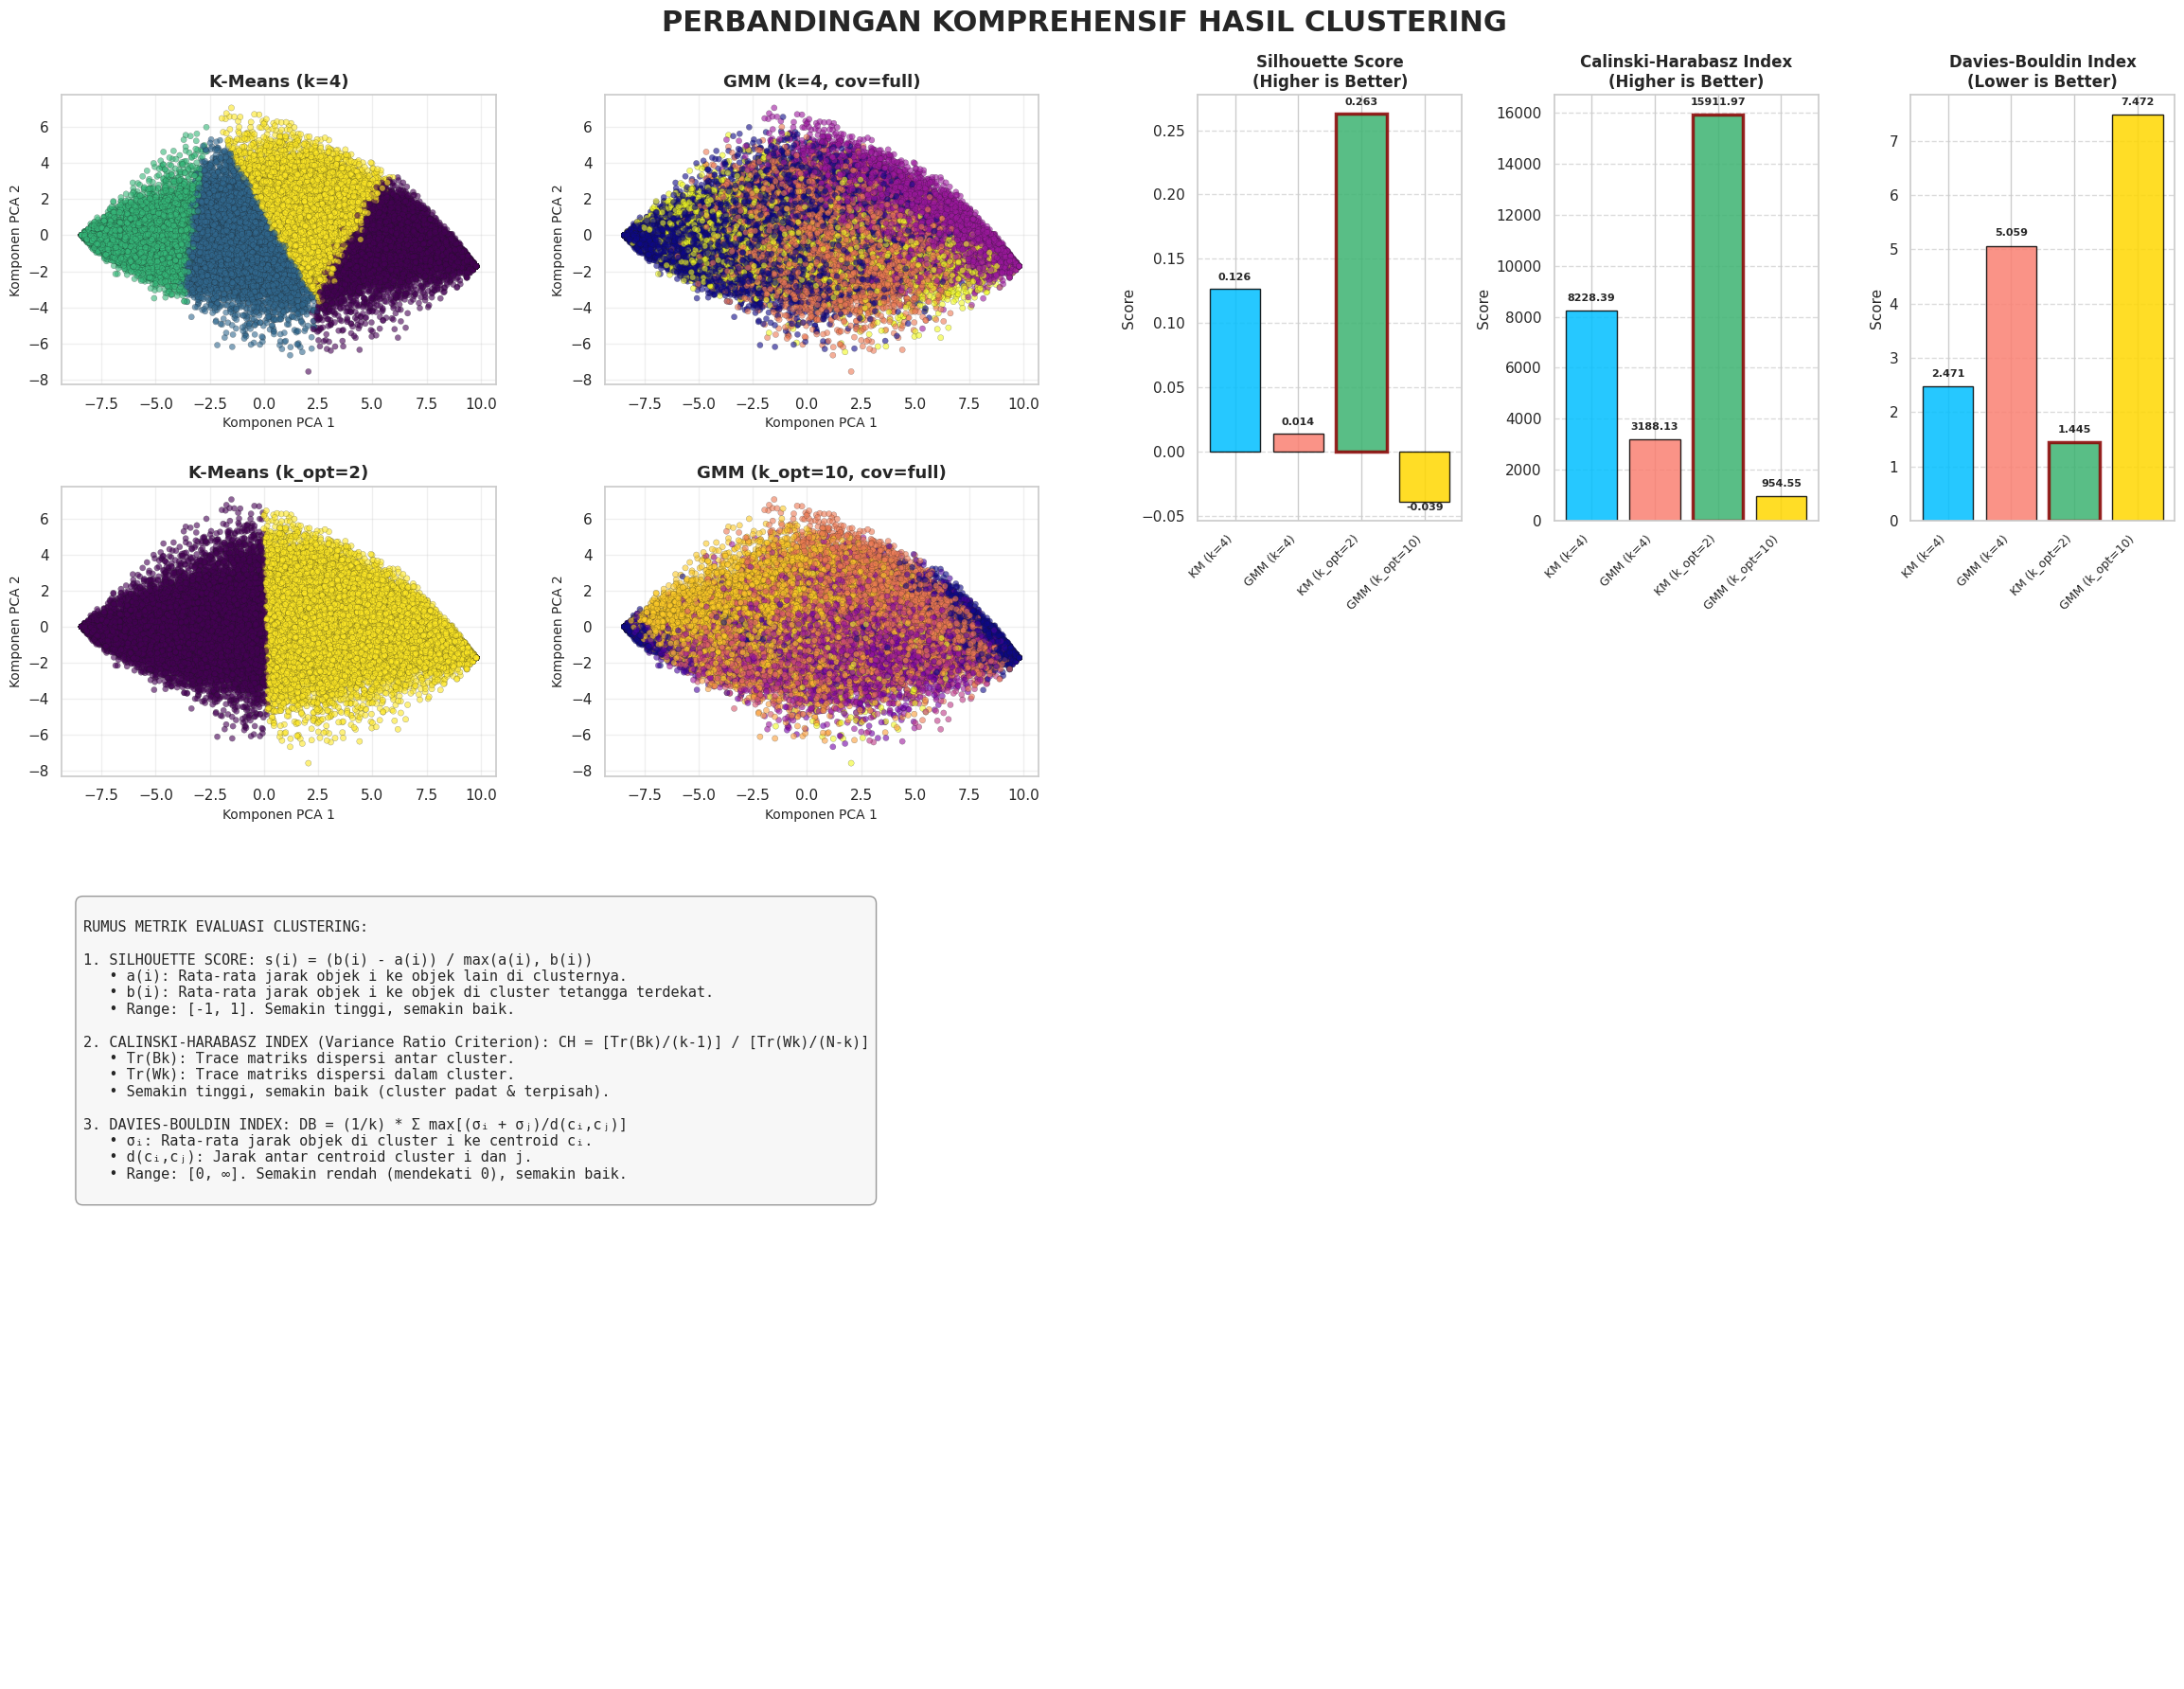

In [ ]:
print("9. Visualisasi Perbandingan Komprehensif")

if X_scaled is not None and eval_summary_df is not None and not eval_summary_df.empty:

    def create_comprehensive_comparison_refactored():

        # Prepare data untuk perbandingan metrik
        scenarios_plot = eval_summary_df.index.tolist()
        silhouette_scores_comp = eval_summary_df['silhouette'].tolist()
        calinski_scores_comp = eval_summary_df['calinski_harabasz'].tolist()
        davies_scores_comp = eval_summary_df['davies_bouldin'].tolist()

        # PCA untuk visualisasi 2D
        pca = PCA(n_components=2, random_state=42)
        X_pca = pca.fit_transform(X_scaled)

        fig = plt.figure(figsize=(24, 18)) # Adjusted size
        plt.suptitle('PERBANDINGAN KOMPREHENSIF HASIL CLUSTERING',
                     fontsize=22, fontweight='bold', y=1.0) # Adjusted y

        # Subplot 1: Clustering Results Visualization (2x2 grid)
        gs1 = fig.add_gridspec(2, 2, left=0.05, right=0.48, top=0.95, bottom=0.55, hspace=0.35, wspace=0.25)

        plot_labels_list = [
            (kmeans_labels_kfixed, 'viridis', f"K-Means (k={K_FIXED_USER_DEFINED})"),
            (gmm_labels_kfixed, 'plasma', f"GMM (k={K_FIXED_USER_DEFINED}, cov={BEST_COVARIANCE_TYPE_GMM})"),
            (kmeans_labels_koptimal, 'viridis', f"K-Means (k_opt={K_OPTIMAL_KMEANS})"),
            (gmm_labels_koptimal, 'plasma', f"GMM (k_opt={K_OPTIMAL_GMM}, cov={BEST_COVARIANCE_TYPE_GMM})")
        ]

        for i, (labels, cmap, title) in enumerate(plot_labels_list):
            ax = fig.add_subplot(gs1[i//2, i%2])
            if labels is not None and len(X_pca) > 0:
                num_points_to_plot = min(len(X_pca), len(labels))
                scatter = ax.scatter(X_pca[:num_points_to_plot, 0], X_pca[:num_points_to_plot, 1],
                                   c=labels[:num_points_to_plot], cmap=cmap, alpha=0.6, s=20,
                                   edgecolor='k', linewidth=0.2)
                # Determine number of unique clusters for legend
                num_unique_clusters = len(np.unique(labels[:num_points_to_plot]))
                # legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f'Klaster {j}',
                #                 markerfacecolor=plt.cm.get_cmap(cmap)(j/max(1,num_unique_clusters-1) if num_unique_clusters > 1 else 0), markersize=8)
                #                 for j in range(num_unique_clusters)]
                # ax.legend(handles=legend_elements, title='Klaster', fontsize=9, loc='best')
            else:
                ax.text(0.5, 0.5, 'Data/Label tidak tersedia', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
            ax.set_title(title, fontweight='bold', fontsize=13)
            ax.set_xlabel('Komponen PCA 1', fontsize=10)
            ax.set_ylabel('Komponen PCA 2', fontsize=10)
            ax.grid(True, alpha=0.3)

        # Subplot 2: Metrics Comparison (3 bar charts)
        gs2 = fig.add_gridspec(1, 3, left=0.55, right=0.98, top=0.95, bottom=0.70, wspace=0.35)

        metrics_plot_data = [
            (silhouette_scores_comp, 'Silhouette Score\n(Higher is Better)', True),
            (calinski_scores_comp, 'Calinski-Harabasz Index\n(Higher is Better)', True),
            (davies_scores_comp, 'Davies-Bouldin Index\n(Lower is Better)', False)
        ]
        # Shorten scenario names for bar chart x-axis labels for better readability
        scenarios_short_names = [
            f"KM (k={K_FIXED_USER_DEFINED})",
            f"GMM (k={K_FIXED_USER_DEFINED})",
            f"KM (k_opt={K_OPTIMAL_KMEANS})",
            f"GMM (k_opt={K_OPTIMAL_GMM})"
        ]

        colors_bar = ['deepskyblue', 'salmon', 'mediumseagreen', 'gold']

        for i, (scores, title, higher_is_better) in enumerate(metrics_plot_data):
            ax = fig.add_subplot(gs2[0, i])
            bars = ax.bar(scenarios_short_names, scores, color=colors_bar, alpha=0.85, edgecolor='black')
            ax.set_title(title, fontweight='bold', fontsize=12) # Reduced font size
            ax.set_ylabel('Score', fontsize=11)
            ax.tick_params(axis='x', rotation=45, labelsize=9)
            for tick in ax.get_xticklabels():
                tick.set_horizontalalignment('right')
            ax.grid(axis='y', linestyle='--', alpha=0.7)

            # Determine valid scores for text annotation positioning
            valid_scores = [s for s in scores if not np.isnan(s)]
            if not valid_scores: valid_scores = [0] # Avoid error if all are NaN

            for bar_idx, bar in enumerate(bars):
                yval = bar.get_height()
                if not np.isnan(yval):
                     ax.text(bar.get_x() + bar.get_width()/2.0,
                             yval + (max(valid_scores) * 0.02 if yval >=0 else min(valid_scores) * 0.02), # Adjust offset based on value
                             f'{yval:.3f}' if abs(yval) < 10 else f'{yval:.2f}', # Format based on magnitude
                             ha='center', va='bottom' if yval >=0 else 'top',
                             fontsize=8, fontweight='bold') # Reduced font size

            # Highlight best score
            if not all(np.isnan(s) for s in scores):
                if higher_is_better:
                    best_idx = np.nanargmax(scores)
                else:
                    best_idx = np.nanargmin(scores)
                if best_idx < len(bars) and not np.isnan(scores[best_idx]): # Check if best_idx is valid
                    bars[best_idx].set_edgecolor('darkred')
                    bars[best_idx].set_linewidth(2.5) # Make highlight more prominent

        # Subplot 3: Evaluation Formulas (Simplified, ADASYN removed)
        gs3 = fig.add_gridspec(1, 1, left=0.05, right=0.98, top=0.48, bottom=0.02)
        ax_formulas = fig.add_subplot(gs3[0, 0])
        ax_formulas.axis('off')

        formula_text = """
RUMUS METRIK EVALUASI CLUSTERING:

1. SILHOUETTE SCORE: s(i) = (b(i) - a(i)) / max(a(i), b(i))
   • a(i): Rata-rata jarak objek i ke objek lain di clusternya.
   • b(i): Rata-rata jarak objek i ke objek di cluster tetangga terdekat.
   • Range: [-1, 1]. Semakin tinggi, semakin baik.

2. CALINSKI-HARABASZ INDEX (Variance Ratio Criterion): CH = [Tr(Bk)/(k-1)] / [Tr(Wk)/(N-k)]
   • Tr(Bk): Trace matriks dispersi antar cluster.
   • Tr(Wk): Trace matriks dispersi dalam cluster.
   • Semakin tinggi, semakin baik (cluster padat & terpisah).

3. DAVIES-BOULDIN INDEX: DB = (1/k) * Σ max[(σᵢ + σⱼ)/d(cᵢ,cⱼ)]
   • σᵢ: Rata-rata jarak objek di cluster i ke centroid cᵢ.
   • d(cᵢ,cⱼ): Jarak antar centroid cluster i dan j.
   • Range: [0, ∞]. Semakin rendah (mendekati 0), semakin baik.
"""
        ax_formulas.text(0.01, 0.99, formula_text, fontsize=11, transform=ax_formulas.transAxes,
                         verticalalignment='top', fontfamily='monospace',
                         bbox=dict(boxstyle="round,pad=0.5", facecolor="whitesmoke", alpha=0.8, edgecolor='gray'))

        plt.tight_layout(rect=[0, 0.02, 1, 0.97])
        plt.show()

    create_comprehensive_comparison_refactored()
else:
    print("Data atau hasil evaluasi tidak lengkap, visualisasi perbandingan komprehensif dilewati.")


### 9. Profiling Cluster Detail

Membuat profil detail untuk setiap cluster yang dihasilkan oleh masing-masing metode. Profil ini mencakup:
* Rata-rata skor Depresi, Kecemasan, dan Stres (berdasarkan skala DASS-42) untuk setiap cluster.
* Distribusi jumlah sampel per cluster.
* Radar chart yang memvisualisasikan profil kesehatan mental (Depresi, Kecemasan, Stres) untuk setiap cluster.


### 10. Profiling Cluster Detail

--- PROFIL CLUSTER K-Means (k_fixed=4) ---

Profil Rata-rata Skor Item DASS-42 per Cluster (skala 0-3):
         Depression_Avg  Anxiety_Avg  Stress_Avg  Count
Cluster                                                
0                 3.484        3.184       3.474   6928
1                 2.142        1.987       2.367  10118
2                 1.474        1.370       1.598   8753
3                 3.133        2.238       2.789   8784


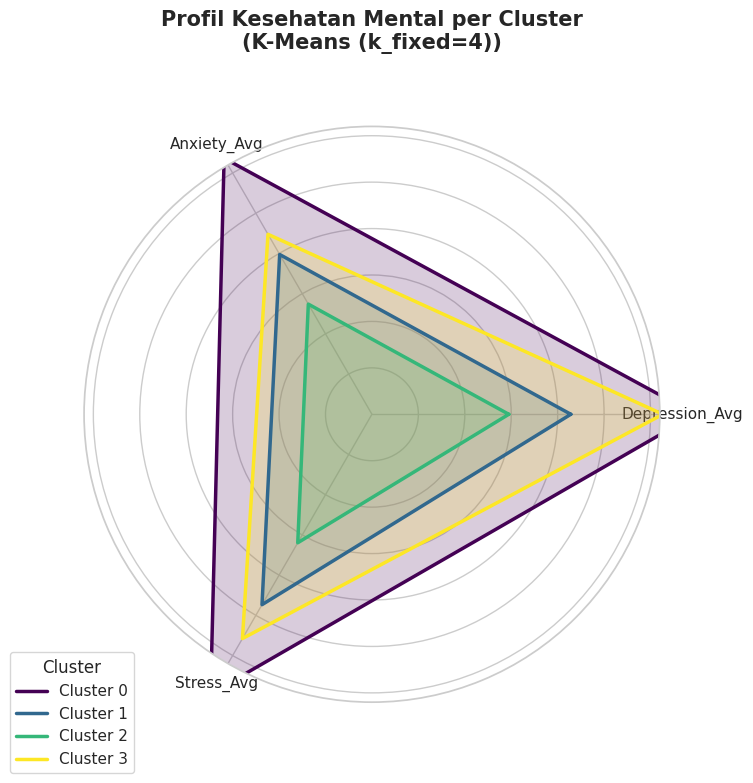


--- PROFIL CLUSTER GMM (k_fixed=4, cov=full) ---

Profil Rata-rata Skor Item DASS-42 per Cluster (skala 0-3):
         Depression_Avg  Anxiety_Avg  Stress_Avg  Count
Cluster                                                
0                 1.922        1.684       2.068  12831
1                 3.603        2.784       3.214   6995
2                 2.579        2.300       2.662   9146
3                 2.277        2.085       2.342   5611


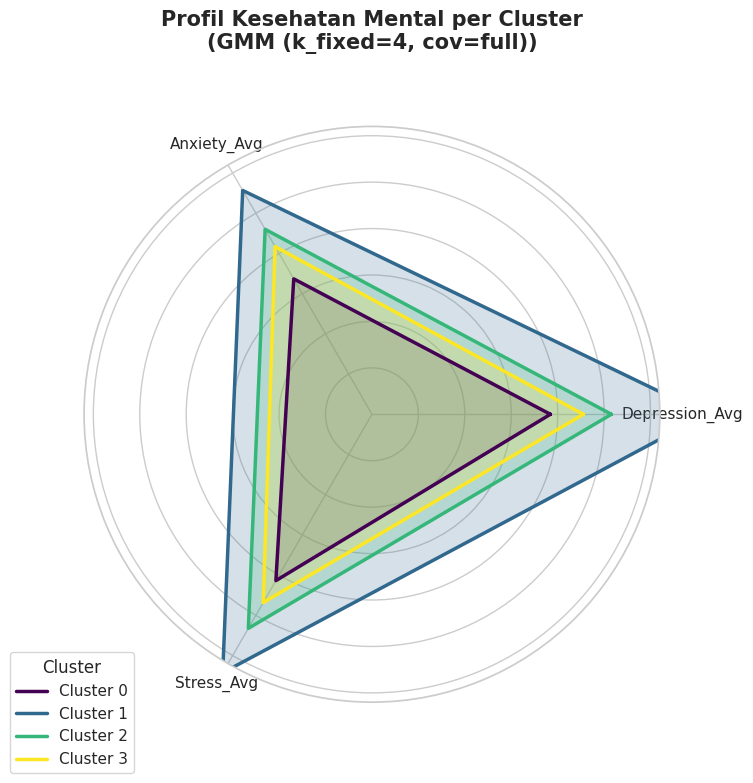


--- PROFIL CLUSTER K-Means (k_optimal=2) ---

Profil Rata-rata Skor Item DASS-42 per Cluster (skala 0-3):
         Depression_Avg  Anxiety_Avg  Stress_Avg  Count
Cluster                                                
0                 1.829        1.621       1.939  17673
1                 3.188        2.671       3.089  16910


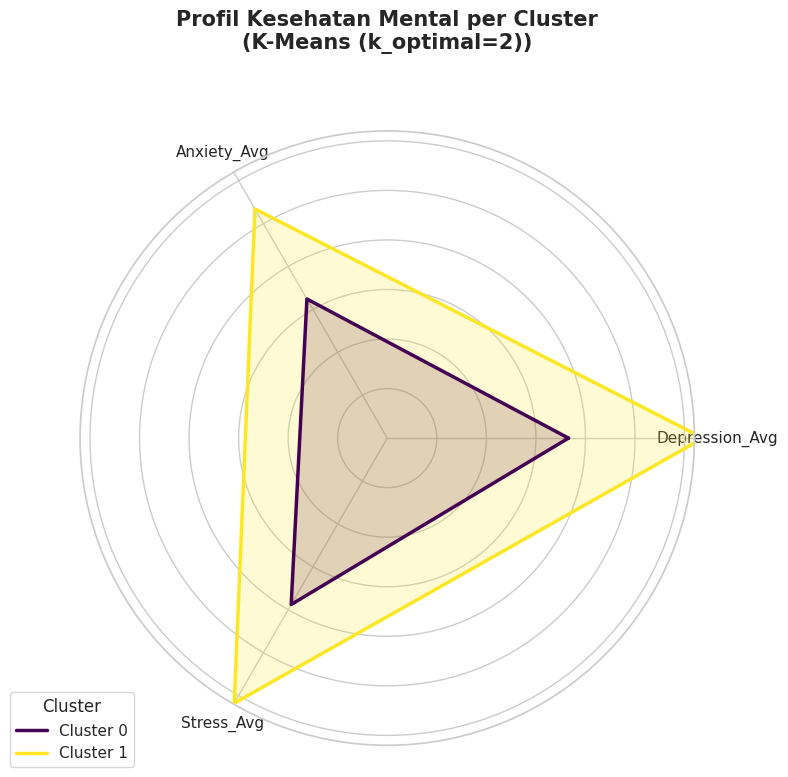


--- PROFIL CLUSTER GMM (k_optimal=10, cov=full) ---

Profil Rata-rata Skor Item DASS-42 per Cluster (skala 0-3):
         Depression_Avg  Anxiety_Avg  Stress_Avg  Count
Cluster                                                
0                 2.940        2.624       2.893   2052
1                 2.004        1.874       2.100   1675
2                 2.725        2.727       2.870   1746
3                 2.501        2.353       2.631   5504
4                 3.161        3.405       3.423    254
5                 2.232        2.003       2.375   4602
6                 3.513        2.619       3.062   5398
7                 2.477        2.433       2.680   2435
8                 2.013        1.549       2.048  10473
9                 2.639        2.733       2.819    444


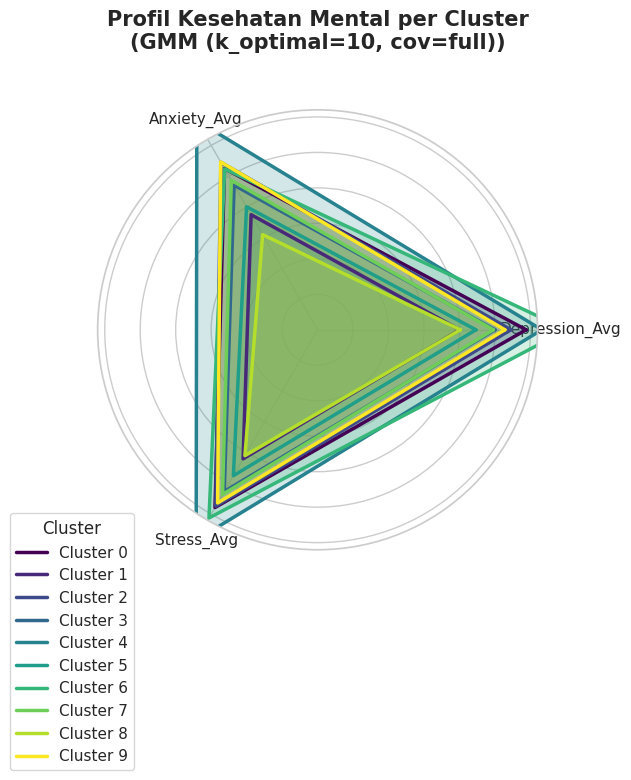

In [ ]:
print("\n### 10. Profiling Cluster Detail")

# Simpan hasil profiling dalam dictionary
cluster_profiles_all_scenarios = {}
clustered_dfs_all_scenarios = {}


if df_final is not None and health_features_cols:
    depression_items = [3, 5, 10, 13, 16, 17, 21, 24, 26, 31, 34, 37, 38, 42]
    anxiety_items = [2, 4, 7, 9, 15, 19, 20, 23, 25, 28, 30, 36, 40, 41]
    stress_items = [1, 6, 8, 11, 12, 14, 18, 22, 27, 29, 32, 33, 35, 39]

    # Pastikan kolom ada di df_final
    depression_cols_q = [f'Q{i}A' for i in depression_items if f'Q{i}A' in df_final.columns]
    anxiety_cols_q = [f'Q{i}A' for i in anxiety_items if f'Q{i}A' in df_final.columns]
    stress_cols_q = [f'Q{i}A' for i in stress_items if f'Q{i}A' in df_final.columns]

    def create_cluster_profiles_refactored(labels_profile, method_name_profile, original_df_profile, num_clusters_expected):
        if labels_profile is None:
            print(f"Label untuk {method_name_profile} tidak tersedia, profiling dilewati.")
            return None, None

        # Pastikan panjang label sesuai dengan df_final (karena semua clustering dilakukan pada X_scaled dari df_final)
        if len(labels_profile) != len(original_df_profile):
            print(f"Peringatan: Panjang label ({len(labels_profile)}) tidak cocok dengan data asli ({len(original_df_profile)}) untuk {method_name_profile}. Profiling mungkin tidak akurat.")
            # Potong atau pad label jika perlu, atau lewati. Untuk sekarang, kita asumsikan cocok.
            # Jika tidak cocok, ini adalah bug di upstream.
            # return None, None # Atau coba potong jika labels_profile lebih panjang (jarang terjadi di sini)
            if len(labels_profile) > len(original_df_profile):
                labels_profile = labels_profile[:len(original_df_profile)]
            else: # labels_profile lebih pendek, ini masalah besar
                 print(f"Label lebih pendek dari data asli, tidak dapat melanjutkan profiling untuk {method_name_profile}.")
                 return None, None


        print(f"\n--- PROFIL CLUSTER {method_name_profile} ---")

        df_with_clusters = original_df_profile.copy()
        df_with_clusters['cluster'] = labels_profile

        # Pastikan semua kolom skala ada sebelum melakukan groupby
        valid_profile_cols = True
        if not depression_cols_q: print("Kolom depresi tidak ada untuk profiling."); valid_profile_cols = False
        if not anxiety_cols_q: print("Kolom kecemasan tidak ada untuk profiling."); valid_profile_cols = False
        if not stress_cols_q: print("Kolom stres tidak ada untuk profiling."); valid_profile_cols = False

        if not valid_profile_cols:
            print(f"Tidak dapat membuat profil DASS untuk {method_name_profile} karena kekurangan kolom.")
            return None, df_with_clusters # Kembalikan df dengan label cluster saja


        # Hitung profil DASS-42 (rata-rata skor per item untuk setiap skala)
        cluster_profiles_list = []
        for cluster_id in sorted(df_with_clusters['cluster'].unique()):
            cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
            profile = {
                'Cluster': cluster_id,
                'Depression_Avg': cluster_data[depression_cols_q].mean().mean() if depression_cols_q else np.nan,
                'Anxiety_Avg': cluster_data[anxiety_cols_q].mean().mean() if anxiety_cols_q else np.nan,
                'Stress_Avg': cluster_data[stress_cols_q].mean().mean() if stress_cols_q else np.nan,
                'Count': len(cluster_data)
            }
            cluster_profiles_list.append(profile)

        cluster_profiles_df = pd.DataFrame(cluster_profiles_list).set_index('Cluster')

        print("\nProfil Rata-rata Skor Item DASS-42 per Cluster (skala 0-3):")
        print(cluster_profiles_df.round(3))

        # Radar Chart
        # Ambil hanya kolom D,A,S untuk radar
        radar_df_data = cluster_profiles_df[['Depression_Avg', 'Anxiety_Avg', 'Stress_Avg']].copy()
        # Hapus baris dengan NaN jika ada, karena radar tidak bisa plot NaN
        radar_df_data.dropna(inplace=True)

        if not radar_df_data.empty:
            labels_radar = radar_df_data.columns
            num_vars = len(labels_radar)
            angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
            angles += angles[:1]

            fig_radar, ax_radar = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
            # Gunakan colormap yang konsisten dengan jumlah cluster yang diharapkan
            radar_colors = plt.cm.get_cmap('viridis', num_clusters_expected)

            for i, (idx, row) in enumerate(radar_df_data.iterrows()):
                values = row.tolist()
                values += values[:1]
                ax_radar.plot(angles, values, label=f'Cluster {idx}', linewidth=2.5, color=radar_colors(i % num_clusters_expected), linestyle='solid')
                ax_radar.fill(angles, values, alpha=0.2, color=radar_colors(i % num_clusters_expected))

            ax_radar.set_yticklabels([])
            ax_radar.set_xticks(angles[:-1])
            ax_radar.set_xticklabels(labels_radar, size=11)
            ax_radar.set_ylim(0, 3.1) # Skala DASS asli 0-3

            plt.title(f'Profil Kesehatan Mental per Cluster\n({method_name_profile})',
                      size=15, fontweight='bold', y=1.12) # Adjusted y
            plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1), title='Cluster')
            plt.tight_layout() # Ensure layout is tight
            plt.show()
        else:
            print(f"Tidak ada data valid untuk radar chart {method_name_profile} (mungkin semua NaN).")

        return cluster_profiles_df, df_with_clusters

    # Profiling untuk semua skenario
    # Pastikan df_final yang digunakan adalah yang SEBELUM X_scaled dibuat, jika X_scaled berasal dari subset kolom.
    # Di sini, X_scaled dibuat dari health_features_cols dari df_final, jadi panjangnya harusnya cocok.

    # Skenario 1
    if kmeans_labels_kfixed is not None:
        profiles_km_kfixed, df_km_kfixed_clustered = create_cluster_profiles_refactored(
            kmeans_labels_kfixed, f"K-Means (k_fixed={K_FIXED_USER_DEFINED})", df_final, K_FIXED_USER_DEFINED)
        if profiles_km_kfixed is not None: cluster_profiles_all_scenarios[f"KM_kfixed_{K_FIXED_USER_DEFINED}"] = profiles_km_kfixed
        if df_km_kfixed_clustered is not None: clustered_dfs_all_scenarios[f"KM_kfixed_{K_FIXED_USER_DEFINED}"] = df_km_kfixed_clustered

    # Skenario 2
    if gmm_labels_kfixed is not None:
        profiles_gmm_kfixed, df_gmm_kfixed_clustered = create_cluster_profiles_refactored(
            gmm_labels_kfixed, f"GMM (k_fixed={K_FIXED_USER_DEFINED}, cov={BEST_COVARIANCE_TYPE_GMM})", df_final, K_FIXED_USER_DEFINED)
        if profiles_gmm_kfixed is not None: cluster_profiles_all_scenarios[f"GMM_kfixed_{K_FIXED_USER_DEFINED}"] = profiles_gmm_kfixed
        if df_gmm_kfixed_clustered is not None: clustered_dfs_all_scenarios[f"GMM_kfixed_{K_FIXED_USER_DEFINED}"] = df_gmm_kfixed_clustered

    # Skenario 3
    if kmeans_labels_koptimal is not None:
        profiles_km_kopt, df_km_kopt_clustered = create_cluster_profiles_refactored(
            kmeans_labels_koptimal, f"K-Means (k_optimal={K_OPTIMAL_KMEANS})", df_final, K_OPTIMAL_KMEANS)
        if profiles_km_kopt is not None: cluster_profiles_all_scenarios[f"KM_kopt_{K_OPTIMAL_KMEANS}"] = profiles_km_kopt
        if df_km_kopt_clustered is not None: clustered_dfs_all_scenarios[f"KM_kopt_{K_OPTIMAL_KMEANS}"] = df_km_kopt_clustered

    # Skenario 4
    if gmm_labels_koptimal is not None:
        profiles_gmm_kopt, df_gmm_kopt_clustered = create_cluster_profiles_refactored(
            gmm_labels_koptimal, f"GMM (k_optimal={K_OPTIMAL_GMM}, cov={BEST_COVARIANCE_TYPE_GMM})", df_final, K_OPTIMAL_GMM)
        if profiles_gmm_kopt is not None: cluster_profiles_all_scenarios[f"GMM_kopt_{K_OPTIMAL_GMM}"] = profiles_gmm_kopt
        if df_gmm_kopt_clustered is not None: clustered_dfs_all_scenarios[f"GMM_kopt_{K_OPTIMAL_GMM}"] = df_gmm_kopt_clustered

else:
    print("Data df_final atau kolom fitur kesehatan tidak tersedia, profiling cluster detail dilewati.")


### 10. Analisis Demografi & Kepribadian per Cluster

Menganalisis karakteristik demografi (usia, pendidikan, gender, urban/rural) dan kepribadian (berdasarkan skor TIPI) untuk setiap cluster. Ini membantu memberikan pemahaman yang lebih kaya tentang komposisi masing-masing cluster. Visualisasi menggunakan boxplot dan bar chart.

11. Analisis Demografi & Kepribadian per Cluster

--- ANALISIS DEMOGRAFI & KEPRIBADIAN: K-Means (k_fixed=4) ---

Profil Rata-rata Demografi Numerik & Kepribadian (TIPI):
           age  familysize  TIPI1  TIPI2  TIPI3  TIPI4  TIPI5  TIPI6  TIPI7  \
cluster                                                                       
0        21.48        3.58   3.40   4.64   4.33   6.32   4.34   5.26   5.23   
1        23.08        3.56   3.93   4.17   4.81   5.24   5.03   4.77   5.32   
2        26.00        3.67   4.33   3.67   5.23   3.73   5.44   4.34   5.35   
3        23.19        3.43   3.41   4.33   4.45   5.66   4.69   5.13   5.22   

         TIPI8  TIPI9  TIPI10  
cluster                        
0         4.89   2.52    4.06  
1         4.22   3.79    3.75  
2         3.66   4.96    3.50  
3         4.55   3.08    3.93  


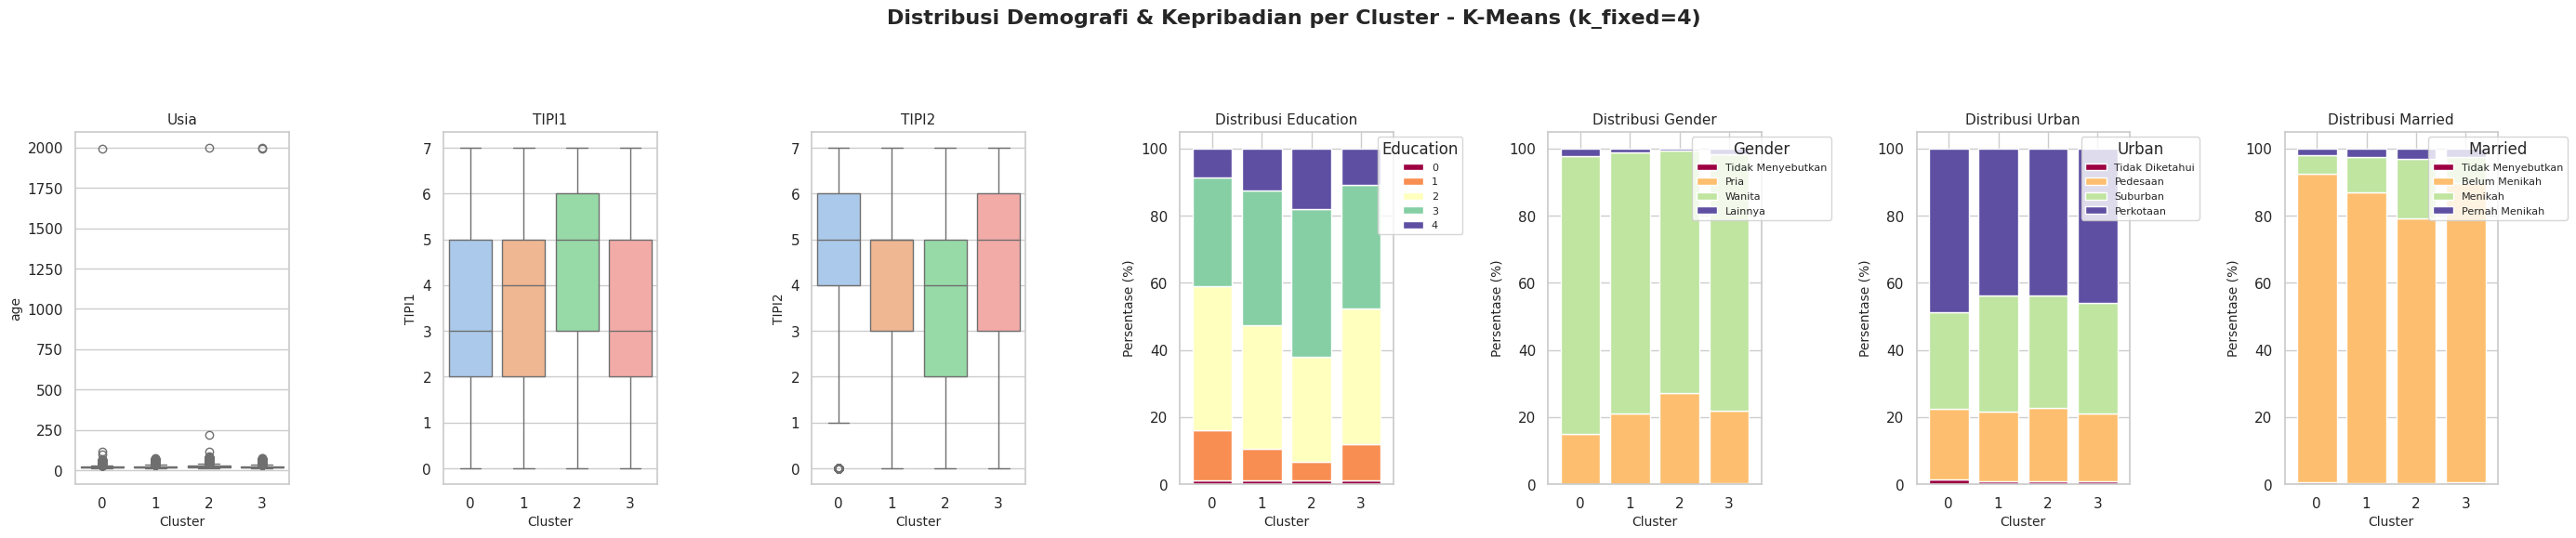


--- ANALISIS DEMOGRAFI & KEPRIBADIAN: GMM (k_fixed=4, cov=full) ---

Profil Rata-rata Demografi Numerik & Kepribadian (TIPI):
           age  familysize  TIPI1  TIPI2  TIPI3  TIPI4  TIPI5  TIPI6  TIPI7  \
cluster                                                                       
0        24.81        3.54   4.05   3.96   4.99   4.54   5.17   4.57   5.35   
1        22.12        3.44   3.25   4.50   4.26   6.06   4.41   5.32   5.17   
2        22.49        3.53   3.79   4.28   4.65   5.51   4.91   4.91   5.29   
3        24.04        3.78   3.89   4.12   4.82   5.02   4.94   4.80   5.27   

         TIPI8  TIPI9  TIPI10  
cluster                        
0         3.94   4.27    3.62  
1         4.84   2.57    4.04  
2         4.43   3.48    3.83  
3         4.20   3.86    3.82  


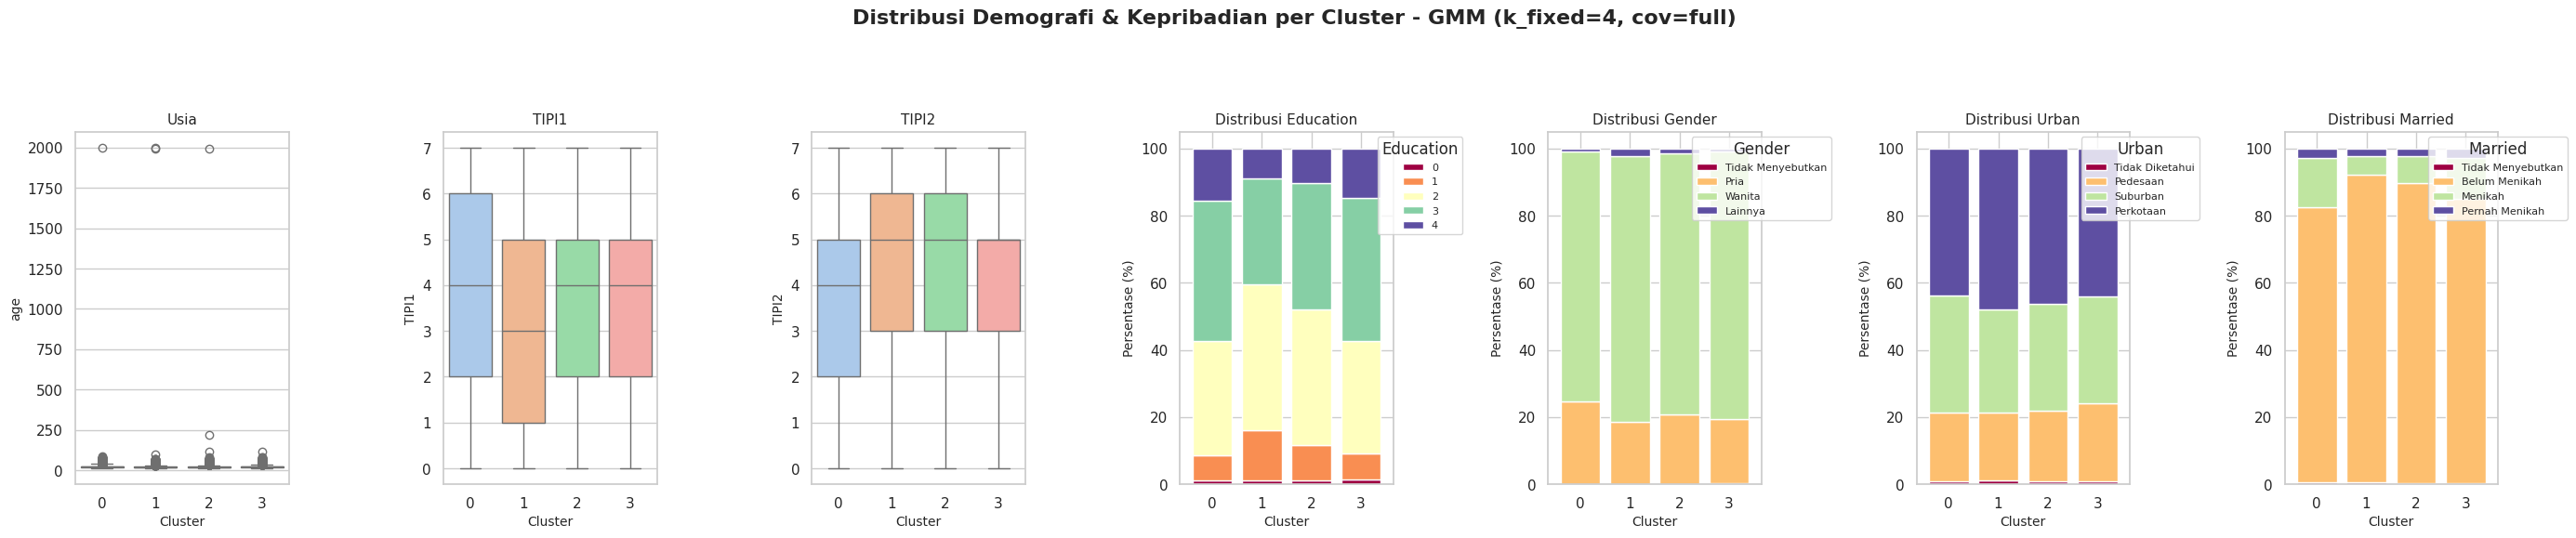


--- ANALISIS DEMOGRAFI & KEPRIBADIAN: K-Means (k_optimal=2) ---

Profil Rata-rata Demografi Numerik & Kepribadian (TIPI):
           age  familysize  TIPI1  TIPI2  TIPI3  TIPI4  TIPI5  TIPI6  TIPI7  \
cluster                                                                       
0        24.68        3.61   4.11   3.90   5.01   4.42   5.24   4.56   5.31   
1        22.32        3.51   3.47   4.47   4.43   5.98   4.57   5.15   5.25   

         TIPI8  TIPI9  TIPI10  
cluster                        
0         3.94   4.40    3.64  
1         4.67   2.87    3.96  


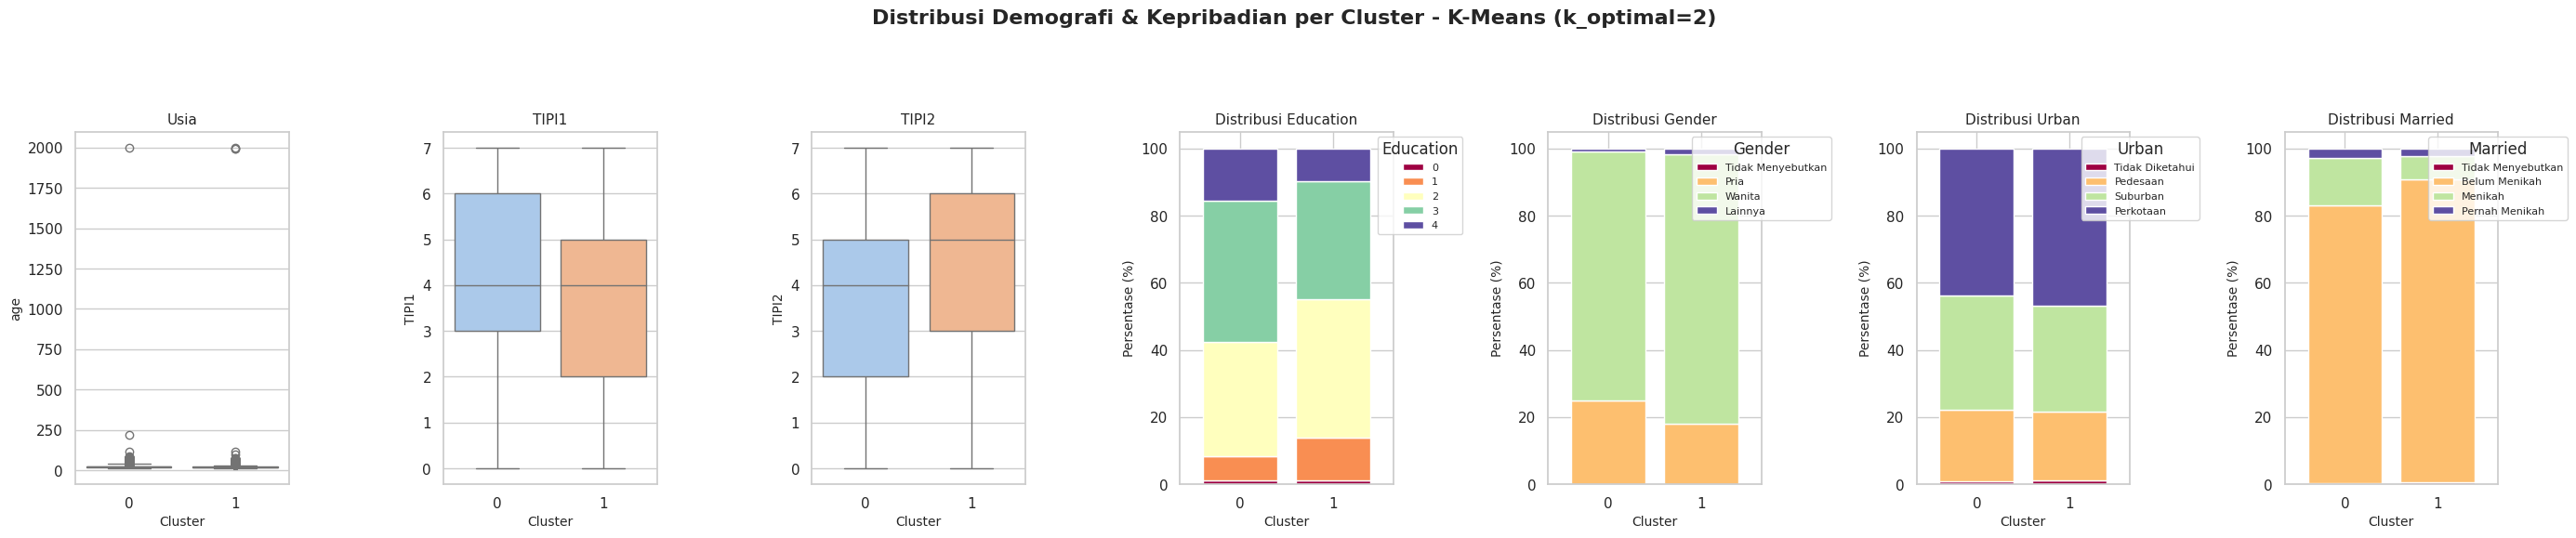


--- ANALISIS DEMOGRAFI & KEPRIBADIAN: GMM (k_optimal=10, cov=full) ---

Profil Rata-rata Demografi Numerik & Kepribadian (TIPI):
           age  familysize  TIPI1  TIPI2  TIPI3  TIPI4  TIPI5  TIPI6  TIPI7  \
cluster                                                                       
0        23.10        3.68   3.62   4.33   4.60   5.16   4.52   4.93   5.13   
1        23.98        3.68   4.21   3.91   5.05   4.32   5.18   4.52   5.38   
2        23.11        3.74   3.80   4.31   4.67   5.69   4.81   4.94   5.28   
3        22.70        3.69   3.83   4.27   4.71   5.48   4.88   4.90   5.30   
4        20.84        3.74   3.70   4.58   4.51   6.13   4.37   5.07   5.26   
5        23.27        3.56   3.90   4.11   4.79   5.17   4.99   4.75   5.36   
6        22.41        3.42   3.30   4.42   4.31   5.93   4.53   5.27   5.20   
7        21.66        3.43   3.82   4.22   4.69   5.58   4.87   4.83   5.33   
8        25.31        3.50   3.94   4.01   4.92   4.57   5.16   4.67   5.29   
9

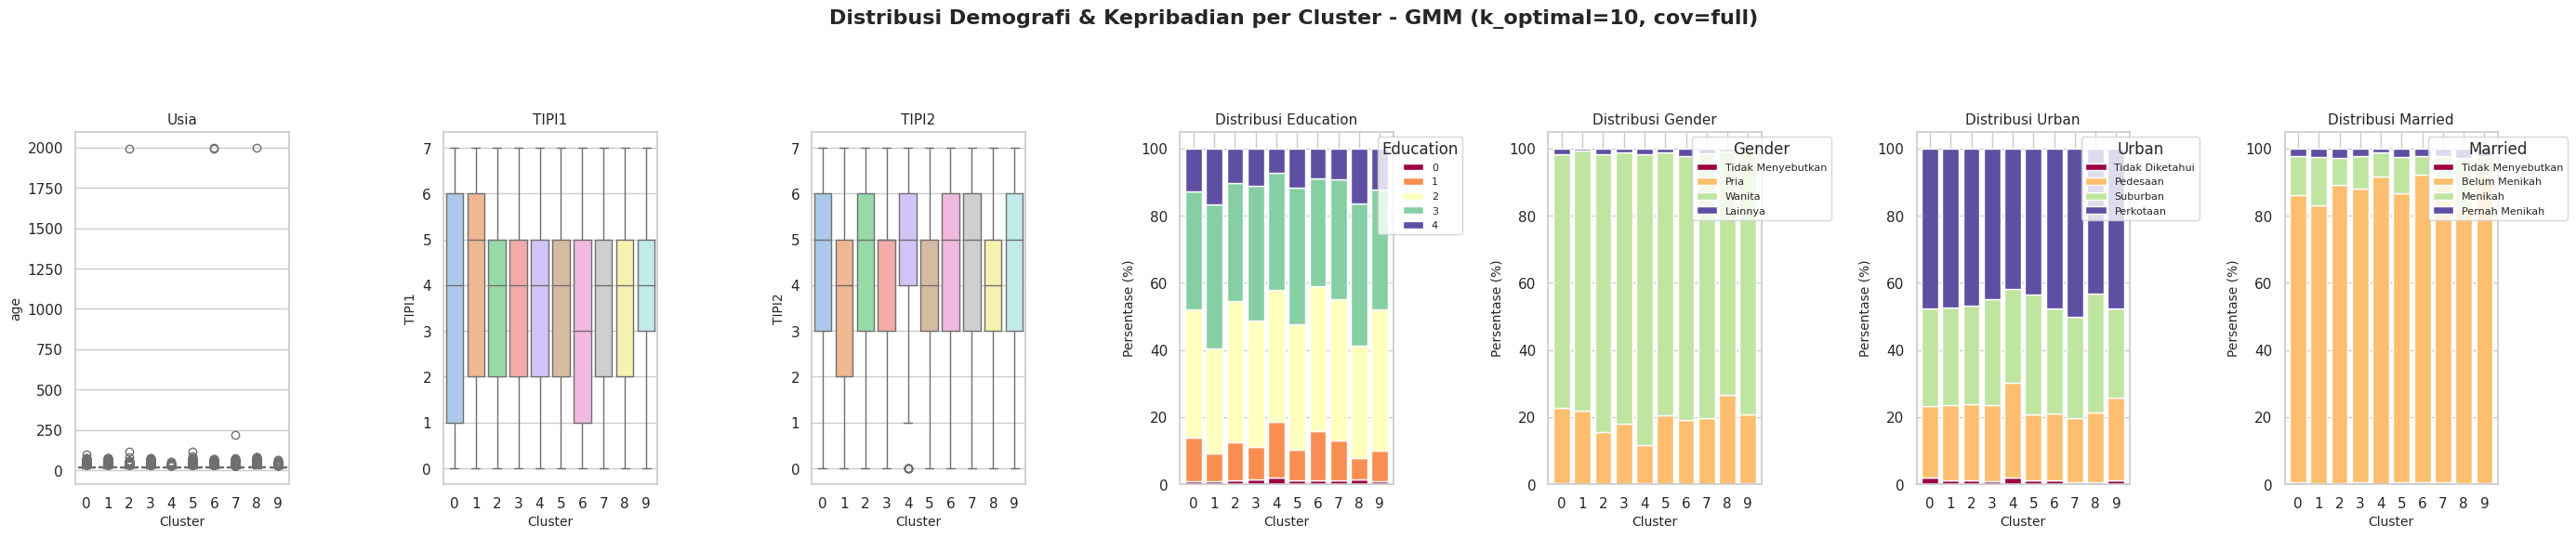

In [ ]:
print("11. Analisis Demografi & Kepribadian per Cluster")

demographic_profiles_all_scenarios = {}

if df_final is not None and profiling_cols: # Membutuhkan df_final untuk data demografi asli dan kolom profiling
    def analyze_demographics_personality_refactored(df_clustered_input, method_name_demo):
        if df_clustered_input is None or 'cluster' not in df_clustered_input.columns:
            print(f"Data berlabel cluster untuk {method_name_demo} tidak tersedia. Analisis demografi dilewati.")
            return None

        print(f"\n--- ANALISIS DEMOGRAFI & KEPRIBADIAN: {method_name_demo} ---")

        # Fitur numerik untuk analisis rata-rata (termasuk TIPI)
        numerical_cols_demo = ['age', 'familysize'] + [f'TIPI{i}' for i in range(1, 11)]
        existing_numerical_cols = [col for col in numerical_cols_demo if col in df_clustered_input.columns]

        if not existing_numerical_cols:
            print(f"Tidak ada kolom numerik (age, familysize, TIPI) yang ditemukan untuk {method_name_demo}.")
        else:
            demographic_profile_num_df = df_clustered_input.groupby('cluster')[existing_numerical_cols].mean()
            print("\nProfil Rata-rata Demografi Numerik & Kepribadian (TIPI):")
            print(demographic_profile_num_df.round(2))

        # Fitur kategorikal untuk analisis distribusi
        categorical_cols_demo = ['education', 'gender', 'urban', 'married', 'religion', 'orientation', 'race', 'hand', 'voted']
        existing_categorical_cols = [col for col in categorical_cols_demo if col in df_clustered_input.columns]

        if not existing_categorical_cols:
            print(f"Tidak ada kolom kategorikal yang ditemukan untuk {method_name_demo}.")
        else:
            # Visualisasi beberapa fitur kategorikal dan numerik terpilih
            # Menyesuaikan jumlah subplot
            num_cat_to_plot = min(len(existing_categorical_cols), 4) # Plot maks 4 fitur kat
            num_num_to_plot = min(len(existing_numerical_cols), 3)   # Plot maks 3 fitur num (misal age, 2 TIPI)

            if num_cat_to_plot + num_num_to_plot == 0:
                print(f"Tidak ada fitur demografi/kepribadian untuk divisualisasikan untuk {method_name_demo}.")
                return demographic_profile_num_df if existing_numerical_cols else None

            fig_demo, axes_demo = plt.subplots(nrows=1, ncols=num_num_to_plot + num_cat_to_plot,
                                               figsize=(max(15, 4 * (num_num_to_plot + num_cat_to_plot)), 5.5)) # Lebar dinamis
            fig_demo.suptitle(f'Distribusi Demografi & Kepribadian per Cluster - {method_name_demo}', fontsize=16, fontweight='bold', y=1.05)

            ax_idx = 0

            # Fitur Numerik (Boxplot) - pilih beberapa yang representatif
            num_plot_cols_map = {'age': 'Usia'}
            tipi_cols_for_plot = [col for col in existing_numerical_cols if 'TIPI' in col]
            if len(tipi_cols_for_plot) >= 2:
                 num_plot_cols_map[tipi_cols_for_plot[0]] = f'{tipi_cols_for_plot[0]}' # Misal TIPI1
                 num_plot_cols_map[tipi_cols_for_plot[1]] = f'{tipi_cols_for_plot[1]}' # Misal TIPI2
            elif tipi_cols_for_plot:
                 num_plot_cols_map[tipi_cols_for_plot[0]] = f'{tipi_cols_for_plot[0]}'


            for col, title in num_plot_cols_map.items():
                if col in existing_numerical_cols and ax_idx < num_num_to_plot:
                    current_ax = axes_demo[ax_idx] if num_num_to_plot + num_cat_to_plot > 1 else axes_demo # Handle single plot case
                    sns.boxplot(x='cluster', y=col, data=df_clustered_input, ax=current_ax, palette='pastel', hue='cluster', legend=False)
                    current_ax.set_title(title, fontsize=11)
                    current_ax.set_xlabel('Cluster', fontsize=10)
                    current_ax.set_ylabel(col, fontsize=10)
                    ax_idx += 1

            # Fitur Kategorikal (Barplot persentase)
            # Define maps for better labels - pastikan nilai dalam data sesuai dengan keys di map
            gender_map = {1.0: 'Pria', 2.0: 'Wanita', 3.0: 'Lainnya', 0.0: 'Tidak Menyebutkan'} # Contoh, sesuaikan
            urban_map = {1.0: 'Pedesaan', 2.0: 'Suburban', 3.0: 'Perkotaan', 0.0: 'Tidak Diketahui'}
            married_map = {1.0: 'Belum Menikah', 2.0: 'Menikah', 3.0: 'Pernah Menikah', 0.0: 'Tidak Menyebutkan'}

            col_maps = {'gender': gender_map, 'urban': urban_map, 'married': married_map}

            for col_idx, col in enumerate(existing_categorical_cols):
                if ax_idx < num_num_to_plot + num_cat_to_plot and col_idx < num_cat_to_plot:
                    current_ax = axes_demo[ax_idx] if num_num_to_plot + num_cat_to_plot > 1 else axes_demo
                    crosstab_data = pd.crosstab(df_clustered_input['cluster'], df_clustered_input[col], normalize='index') * 100

                    # Apply mapping if exists
                    if col in col_maps:
                        # Only map columns that exist in the crosstab_data
                        current_map = col_maps[col]
                        crosstab_data.columns = [current_map.get(c_val, c_val) for c_val in crosstab_data.columns]

                    crosstab_data.plot(kind='bar', stacked=True, ax=current_ax, colormap='Spectral',
                                       width=0.8) # Adjusted width
                    current_ax.set_title(f'Distribusi {col.capitalize()}', fontsize=11)
                    current_ax.set_xlabel('Cluster', fontsize=10)
                    current_ax.set_ylabel('Persentase (%)', fontsize=10)
                    current_ax.legend(title=col.capitalize(), fontsize=8, loc='upper right', bbox_to_anchor=(1.35, 1.0)) # Adjust legend
                    current_ax.tick_params(axis='x', rotation=0)
                    ax_idx += 1

            # Matikan axes yang tidak terpakai
            if num_num_to_plot + num_cat_to_plot > 1: # hanya jika ada multiple axes
                for i in range(ax_idx, len(axes_demo)):
                    axes_demo[i].axis('off')

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

        return demographic_profile_num_df if existing_numerical_cols else None


    # Analisis untuk semua skenario yang memiliki dataframe berlabel cluster
    for scenario_name, df_clustered in clustered_dfs_all_scenarios.items():
        # method_name_parts = scenario_name.split('_') # e.g. "KM_kfixed_4" -> ["KM", "kfixed", "4"]
        # full_method_name = f"{method_name_parts[0]} ({method_name_parts[1]}={method_name_parts[2]})"
        # Ganti dengan nama skenario yang lebih deskriptif dari eval_summary_df jika ada
        descriptive_name = scenario_name # Default
        if eval_summary_df is not None: # Cari nama deskriptif dari summary
            for idx_name in eval_summary_df.index:
                if scenario_name.startswith("KM_kfixed") and f"K-Means (k_fixed={K_FIXED_USER_DEFINED})" in idx_name:
                    descriptive_name = idx_name; break
                if scenario_name.startswith("GMM_kfixed") and f"GMM (k_fixed={K_FIXED_USER_DEFINED}" in idx_name:
                    descriptive_name = idx_name; break
                if scenario_name.startswith("KM_kopt") and f"K-Means (k_optimal={K_OPTIMAL_KMEANS})" in idx_name:
                    descriptive_name = idx_name; break
                if scenario_name.startswith("GMM_kopt") and f"GMM (k_optimal={K_OPTIMAL_GMM}" in idx_name:
                    descriptive_name = idx_name; break

        demo_profile = analyze_demographics_personality_refactored(df_clustered, descriptive_name)
        if demo_profile is not None:
            demographic_profiles_all_scenarios[scenario_name] = demo_profile
else:
    print("Data df_final atau kolom profiling tidak tersedia, analisis demografi & kepribadian dilewati.")


### 11. Visualisasi Lanjutan

Membuat visualisasi yang lebih mendalam untuk analisis clustering, meliputi:
* Visualisasi 3D PCA untuk hasil clustering K-Means dan GMM.
* Perbandingan ukuran (jumlah sampel) masing-masing cluster.
* Heatmap korelasi antar fitur DASS (subset) per cluster (contoh untuk K-Means).
* Analisis homogenitas cluster (berdasarkan rata-rata varians fitur dalam cluster).
* Analisis stabilitas clustering (dengan menjalankan algoritma beberapa kali dengan random seed berbeda dan melihat variasi Silhouette Score).

11. Visualisasi Lanjutan
Catatan: K_OPTIMAL_KMEANS (2) berbeda dengan K_OPTIMAL_GMM (10). Plot homogenitas mungkin perlu disesuaikan.


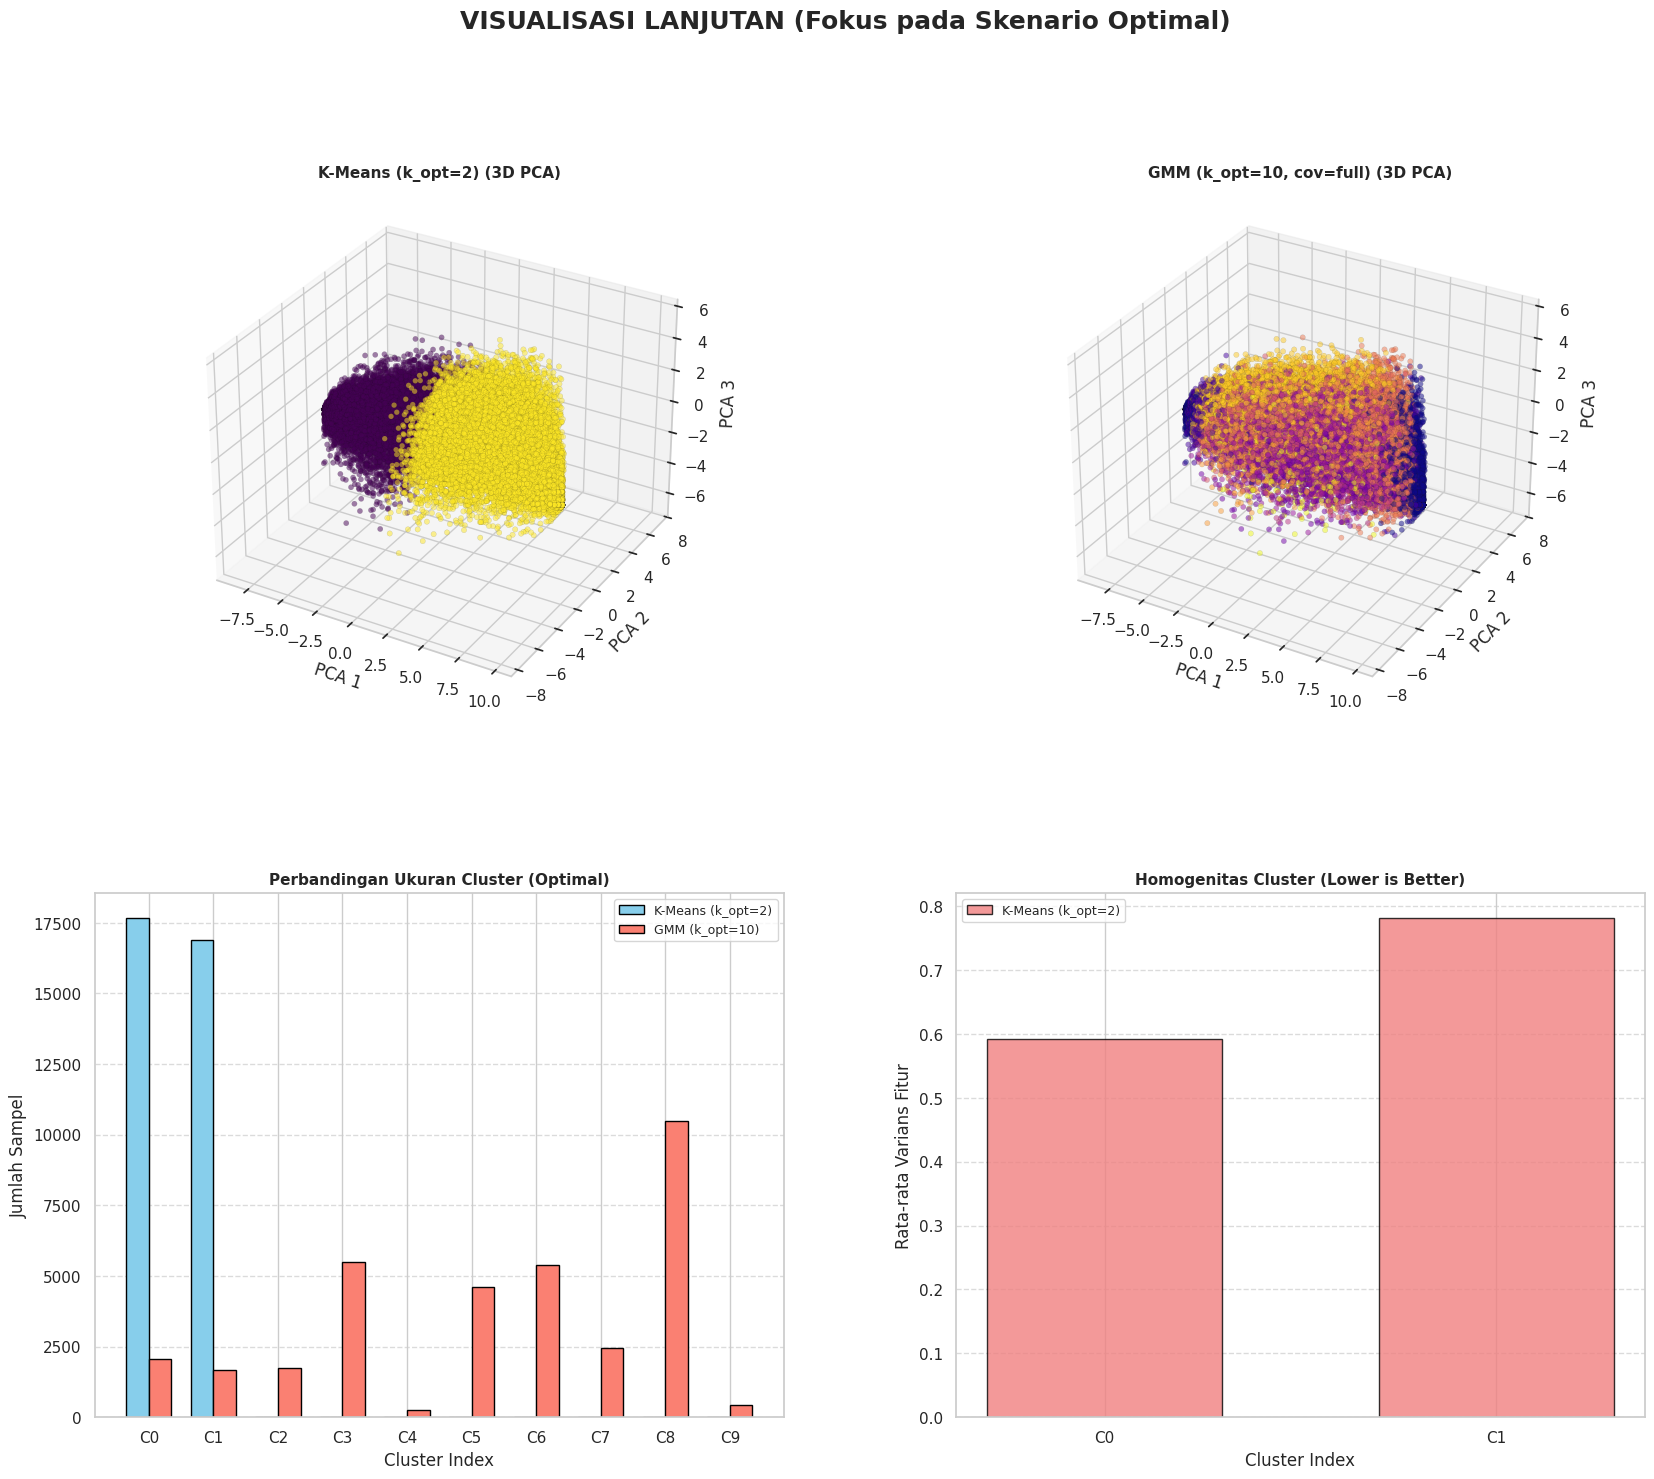

In [ ]:
print("11. Visualisasi Lanjutan")

if X_scaled is not None and K_OPTIMAL_KMEANS and K_OPTIMAL_GMM and BEST_COVARIANCE_TYPE_GMM \
   and kmeans_labels_koptimal is not None and gmm_labels_koptimal is not None:

    def create_advanced_visualization_refactored():
        pca_3d = PCA(n_components=3, random_state=42)
        X_pca_3d = pca_3d.fit_transform(X_scaled)

        fig_adv = plt.figure(figsize=(20, 16)) # Adjusted size
        plt.suptitle('VISUALISASI LANJUTAN (Fokus pada Skenario Optimal)', fontsize=18, fontweight='bold', y=0.99)
        gs_adv = fig_adv.add_gridspec(2, 2, hspace=0.35, wspace=0.25) # 2x2 grid

        # 1. 3D Plot untuk K-Means Optimal
        ax1 = fig_adv.add_subplot(gs_adv[0, 0], projection='3d')
        ax1.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                    c=kmeans_labels_koptimal, cmap='viridis', alpha=0.5, s=15, edgecolor='k', linewidth=0.1)
        ax1.set_title(f'K-Means (k_opt={K_OPTIMAL_KMEANS}) (3D PCA)', fontweight='bold', fontsize=11)
        ax1.set_xlabel('PCA 1'); ax1.set_ylabel('PCA 2'); ax1.set_zlabel('PCA 3')

        # 2. 3D Plot untuk GMM Optimal
        ax2 = fig_adv.add_subplot(gs_adv[0, 1], projection='3d')
        ax2.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                    c=gmm_labels_koptimal, cmap='plasma', alpha=0.5, s=15, edgecolor='k', linewidth=0.1)
        ax2.set_title(f'GMM (k_opt={K_OPTIMAL_GMM}, cov={BEST_COVARIANCE_TYPE_GMM}) (3D PCA)', fontweight='bold', fontsize=11)
        ax2.set_xlabel('PCA 1'); ax2.set_ylabel('PCA 2'); ax2.set_zlabel('PCA 3')

        # 3. Perbandingan Ukuran Cluster (untuk skenario optimal)
        ax3 = fig_adv.add_subplot(gs_adv[1, 0])
        cluster_sizes_kmeans_opt = pd.Series(kmeans_labels_koptimal).value_counts().sort_index()
        cluster_sizes_gmm_opt = pd.Series(gmm_labels_koptimal).value_counts().sort_index()

        num_clusters_plot = max(len(cluster_sizes_kmeans_opt), len(cluster_sizes_gmm_opt), K_OPTIMAL_KMEANS, K_OPTIMAL_GMM)
        k_labels_plot = [f'C{i}' for i in range(num_clusters_plot)]
        x_indices = np.arange(num_clusters_plot)
        width = 0.35

        kmeans_vals = [cluster_sizes_kmeans_opt.get(i, 0) for i in range(num_clusters_plot)]
        gmm_vals = [cluster_sizes_gmm_opt.get(i, 0) for i in range(num_clusters_plot)]

        ax3.bar(x_indices - width/2, kmeans_vals, width, label=f'K-Means (k_opt={K_OPTIMAL_KMEANS})', color='skyblue', edgecolor='black')
        ax3.bar(x_indices + width/2, gmm_vals, width, label=f'GMM (k_opt={K_OPTIMAL_GMM})', color='salmon', edgecolor='black')
        ax3.set_xlabel('Cluster Index'); ax3.set_ylabel('Jumlah Sampel')
        ax3.set_title('Perbandingan Ukuran Cluster (Optimal)', fontweight='bold', fontsize=11)
        ax3.set_xticks(x_indices); ax3.set_xticklabels(k_labels_plot)
        ax3.legend(fontsize=9); ax3.grid(axis='y', linestyle='--', alpha=0.7)

        # 4. Homogenitas Cluster (Rata-rata Varians Fitur Dalam Cluster - untuk skenario optimal)
        ax4 = fig_adv.add_subplot(gs_adv[1, 1])
        feature_variance_kmeans_opt = []
        for i in range(K_OPTIMAL_KMEANS): # Iterasi sesuai jumlah cluster optimal KM
            cluster_data_km = X_scaled[kmeans_labels_koptimal == i]
            if cluster_data_km.shape[0] > 0:
                feature_variance_kmeans_opt.append(np.var(cluster_data_km, axis=0).mean())
            else: feature_variance_kmeans_opt.append(np.nan)

        feature_variance_gmm_opt = []
        for i in range(K_OPTIMAL_GMM): # Iterasi sesuai jumlah cluster optimal GMM
            cluster_data_gmm = X_scaled[gmm_labels_koptimal == i]
            if cluster_data_gmm.shape[0] > 0:
                feature_variance_gmm_opt.append(np.var(cluster_data_gmm, axis=0).mean())
            else: feature_variance_gmm_opt.append(np.nan)

        # Plotting varians, perlu penyesuaian jika K_OPTIMAL_KMEANS != K_OPTIMAL_GMM
        # Untuk simple plot, kita plot keduanya secara terpisah atau hanya satu jika k berbeda signifikan
        # Di sini, kita plot K-Means optimal saja untuk kejelasan jika K berbeda
        if K_OPTIMAL_KMEANS == K_OPTIMAL_GMM:
            x_var = np.arange(K_OPTIMAL_KMEANS)
            ax4.bar(x_var - 0.2, feature_variance_kmeans_opt, 0.4, label='K-Means (Optimal)', color='lightcoral', edgecolor='black', alpha=0.8)
            ax4.bar(x_var + 0.2, feature_variance_gmm_opt, 0.4, label='GMM (Optimal)', color='mediumpurple', edgecolor='black', alpha=0.8)
            ax4.set_xticks(x_var); ax4.set_xticklabels([f'C{i}' for i in x_var])
        else: # Jika K berbeda, plot K-Means saja atau GMM saja, atau adaptasi lain
            x_var_km = np.arange(K_OPTIMAL_KMEANS)
            ax4.bar(x_var_km, feature_variance_kmeans_opt, 0.6, label=f'K-Means (k_opt={K_OPTIMAL_KMEANS})', color='lightcoral', edgecolor='black', alpha=0.8)
            # Tambahkan GMM jika diinginkan, mungkin dengan sumbu x kedua atau plot terpisah
            print(f"Catatan: K_OPTIMAL_KMEANS ({K_OPTIMAL_KMEANS}) berbeda dengan K_OPTIMAL_GMM ({K_OPTIMAL_GMM}). Plot homogenitas mungkin perlu disesuaikan.")
            ax4.set_xticks(x_var_km); ax4.set_xticklabels([f'C{i}' for i in x_var_km])


        ax4.set_xlabel('Cluster Index'); ax4.set_ylabel('Rata-rata Varians Fitur')
        ax4.set_title('Homogenitas Cluster (Lower is Better)', fontweight='bold', fontsize=11)
        ax4.legend(fontsize=9); ax4.grid(axis='y', linestyle='--', alpha=0.7)

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    create_advanced_visualization_refactored()
else:
    print("Data tidak lengkap untuk visualisasi lanjutan, langkah ini dilewati.")


### 12. Evaluasi Final & Ringkasan Perbandingan

Membuat ringkasan evaluasi final dari semua metode clustering yang telah diuji. Ini mencakup:
* Tabel ringkasan yang membandingkan Silhouette Score, Calinski-Harabasz Index, Davies-Bouldin Index, dan ukuran data untuk setiap skenario.
* Peringkat metode berdasarkan masing-masing metrik.
* Rekomendasi metode terbaik berdasarkan skor keseluruhan yang dinormalisasi.
* Heatmap yang memvisualisasikan perbandingan performa semua metode berdasarkan skor yang dinormalisasi.

12. Evaluasi Final & Ringkasan Perbandingan

RINGKASAN EVALUASI SEMUA METODE (REFRESH):
                                                  scenario  silhouette  \
K-Means (k_fixed=4)                    K-Means (k_fixed=4)      0.1263   
GMM (k_fixed=4, cov=full)        GMM (k_fixed=4, cov=full)      0.0139   
K-Means (k_optimal=2)                K-Means (k_optimal=2)      0.2626   
GMM (k_optimal=10, cov=full)  GMM (k_optimal=10, cov=full)     -0.0388   

                              calinski_harabasz  davies_bouldin  Data Size  
K-Means (k_fixed=4)                   8228.3887          2.4709      34583  
GMM (k_fixed=4, cov=full)             3188.1346          5.0587      34583  
K-Means (k_optimal=2)                15911.9711          1.4445      34583  
GMM (k_optimal=10, cov=full)           954.5466          7.4720      34583  

SKOR TERNORMALISASI & KESELURUHAN:
                                                  scenario  silhouette_norm  \
K-Means (k_fixed=4)                    K-

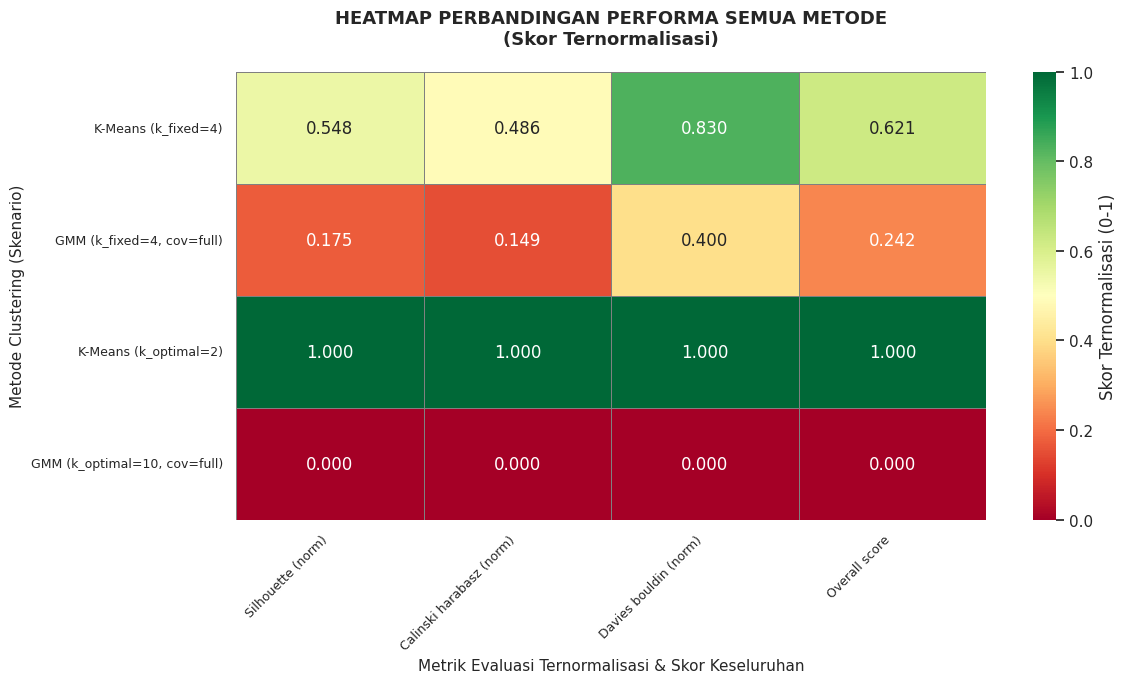

In [ ]:
print("12. Evaluasi Final & Ringkasan Perbandingan")
final_summary_normalized_df = None
best_method_overall = "Tidak dapat ditentukan"

if eval_summary_df is not None and not eval_summary_df.empty:

    final_results_summary_df = eval_summary_df.copy()
    final_results_summary_df['Data Size'] = X_scaled.shape[0] # Semua dari X_scaled

    print("\nRINGKASAN EVALUASI SEMUA METODE (REFRESH):")
    print("="*80)
    print(final_results_summary_df.round(4))

    # Normalisasi untuk skor keseluruhan (MinMax)
    # Hanya normalisasi jika ada lebih dari 1 nilai unik dan tidak semua NaN
    normalized_scores = final_results_summary_df.copy()

    metrics_to_normalize = {
        'silhouette': True, # Higher is better
        'calinski_harabasz': True, # Higher is better
        'davies_bouldin': False # Lower is better
    }

    for metric, higher_is_better in metrics_to_normalize.items():
        col_name = metric
        norm_col_name = f"{metric}_norm"

        # Cek apakah kolom ada dan valid untuk normalisasi
        if col_name in normalized_scores.columns and \
           normalized_scores[col_name].notna().sum() > 0 and \
           normalized_scores[col_name].nunique(dropna=True) > 1 : # Perlu >1 nilai unik

            min_val = normalized_scores[col_name].min()
            max_val = normalized_scores[col_name].max()

            if (max_val - min_val) != 0:
                if higher_is_better:
                    normalized_scores[norm_col_name] = (normalized_scores[col_name] - min_val) / (max_val - min_val)
                else: # Lower is better
                    normalized_scores[norm_col_name] = 1 - ((normalized_scores[col_name] - min_val) / (max_val - min_val))
            else: # Semua nilai sama (setelah dropna)
                normalized_scores[norm_col_name] = 0.5 # Assign nilai tengah
        elif col_name in normalized_scores.columns and normalized_scores[col_name].notna().sum() > 0 : # Ada nilai tapi hanya 1 unik
             normalized_scores[norm_col_name] = 0.5
        else: # Kolom tidak ada atau semua NaN
            normalized_scores[norm_col_name] = 0.0 # Default jika tidak bisa dinormalisasi


    # Hitung Overall Score (rata-rata dari skor ternormalisasi)
    norm_cols_for_overall = [f"{m}_norm" for m in metrics_to_normalize.keys() if f"{m}_norm" in normalized_scores.columns]
    if norm_cols_for_overall: # Pastikan ada kolom ternormalisasi
        normalized_scores['Overall_Score'] = normalized_scores[norm_cols_for_overall].mean(axis=1)

        print("\nSKOR TERNORMALISASI & KESELURUHAN:")
        print(normalized_scores[['scenario'] + norm_cols_for_overall + ['Overall_Score']].round(3))

        if 'Overall_Score' in normalized_scores.columns and normalized_scores['Overall_Score'].notna().any():
            best_method_overall = normalized_scores.loc[normalized_scores['Overall_Score'].idxmax(), 'scenario']
            best_overall_score_val = normalized_scores['Overall_Score'].max()
            print(f"\nMETODE TERBAIK (berdasarkan skor normalisasi gabungan): {best_method_overall} (Skor: {best_overall_score_val:.3f})")
            final_summary_normalized_df = normalized_scores # Simpan untuk heatmap
        else:
            print("\nTidak dapat menentukan metode terbaik dari skor keseluruhan (mungkin semua NaN).")
            final_summary_normalized_df = normalized_scores # Simpan apa adanya

        # Visualisasi final comparison heatmap
        if final_summary_normalized_df is not None and 'Overall_Score' in final_summary_normalized_df.columns:
            plt.figure(figsize=(12, 7))
            # Ambil kolom _norm dan Overall_Score, gunakan 'scenario' sebagai index
            heatmap_data = final_summary_normalized_df.set_index('scenario')[norm_cols_for_overall + ['Overall_Score']]

            # Ganti nama kolom untuk tampilan lebih baik
            heatmap_cols_display = [col.replace('_norm', ' (Norm)').replace('_', ' ').capitalize() for col in heatmap_data.columns]
            heatmap_data.columns = heatmap_cols_display

            sns.heatmap(heatmap_data, annot=True, cmap='RdYlGn', center=0.5,
                        fmt='.3f', cbar_kws={'label': 'Skor Ternormalisasi (0-1)'}, linewidths=.5, linecolor='gray')
            plt.title('HEATMAP PERBANDINGAN PERFORMA SEMUA METODE\n(Skor Ternormalisasi)',
                      fontweight='bold', fontsize=13, pad=20)
            plt.ylabel('Metode Clustering (Skenario)', fontsize=11)
            plt.xlabel('Metrik Evaluasi Ternormalisasi & Skor Keseluruhan', fontsize=11)
            plt.xticks(rotation=45, ha='right', fontsize=9)
            plt.yticks(fontsize=9)
            plt.tight_layout()
            plt.show()
        else:
            print("Tidak dapat membuat heatmap (data normalisasi atau skor keseluruhan tidak tersedia).")
    else:
        print("Tidak ada kolom ternormalisasi yang valid untuk menghitung skor keseluruhan.")

else:
    print("Data evaluasi (eval_summary_df) tidak lengkap, ringkasan evaluasi final dilewati.")
    final_results_summary_df = None

### 13. Penyimpanan Hasil

Menyimpan hasil akhir analisis ke dalam file CSV. Ini mencakup:
* `clustering_results_final.csv`: Dataset asli `df_final` dengan tambahan kolom label cluster dari K-Means (original) dan GMM (original).
* `evaluation_summary.csv`: Tabel ringkasan evaluasi semua metode.

In [ ]:
print("13. Penyimpanan Hasil")

try:
    if df_final is not None and not df_final.empty:
        df_to_save = df_final.copy()

        # Tambahkan label dari semua skenario
        # Nama kolom akan: kmeans_kfixed_4_cluster, gmm_kfixed_4_cov_full_cluster, dst.

        if kmeans_labels_kfixed is not None and len(kmeans_labels_kfixed) == len(df_to_save):
            df_to_save[f'kmeans_kfixed_{K_FIXED_USER_DEFINED}_cluster'] = kmeans_labels_kfixed

        if gmm_labels_kfixed is not None and len(gmm_labels_kfixed) == len(df_to_save):
            df_to_save[f'gmm_kfixed_{K_FIXED_USER_DEFINED}_cov_{BEST_COVARIANCE_TYPE_GMM}_cluster'] = gmm_labels_kfixed

        if kmeans_labels_koptimal is not None and len(kmeans_labels_koptimal) == len(df_to_save):
            df_to_save[f'kmeans_koptimal_{K_OPTIMAL_KMEANS}_cluster'] = kmeans_labels_koptimal

        if gmm_labels_koptimal is not None and len(gmm_labels_koptimal) == len(df_to_save):
            df_to_save[f'gmm_koptimal_{K_OPTIMAL_GMM}_cov_{BEST_COVARIANCE_TYPE_GMM}_cluster'] = gmm_labels_koptimal

        df_to_save.to_csv('clustering_results_all_scenarios.csv', index=False)
        print("  • clustering_results_all_scenarios.csv - Data asli dengan label dari semua skenario telah disimpan.")
    else:
        print("  Dataset df_final tidak tersedia atau kosong, penyimpanan data dengan label dilewati.")

    if final_summary_normalized_df is not None and not final_summary_normalized_df.empty:
        final_summary_normalized_df.to_csv('clustering_evaluation_summary_refactored.csv', index=True) # Index=True karena scenario jadi index
        print("  • clustering_evaluation_summary_refactored.csv - Ringkasan evaluasi (termasuk normalisasi) telah disimpan.")
    elif final_results_summary_df is not None and not final_results_summary_df.empty : # Jika normalisasi gagal tapi summary dasar ada
        final_results_summary_df.to_csv('clustering_evaluation_summary_refactored.csv', index=True)
        print("  • clustering_evaluation_summary_refactored.csv - Ringkasan evaluasi dasar telah disimpan.")
    else:
        print("  Ringkasan evaluasi tidak tersedia, penyimpanan dilewati.")

except Exception as e_save:
    print(f"Error saat menyimpan hasil: {e_save}")

print(f"\n{'='*80}")
print("ANALISIS CLUSTERING (REFACTORED) SELESAI!")
print(f"{'='*80}")
if best_method_overall != "Tidak dapat ditentukan":
    print(f"Metode terbaik yang direkomendasikan (berdasarkan skor gabungan): {best_method_overall}")
else:
    print("Metode terbaik tidak dapat ditentukan secara pasti dari analisis ini.")
print("Semua visualisasi dan evaluasi yang relevan telah ditampilkan dalam notebook ini.")
print(f"Jangan lupa untuk menyesuaikan 'K_FIXED_USER_DEFINED' di Bagian 2, Sel 5, setelah menganalisis output.")
print(f"{'='*80}")


13. Penyimpanan Hasil
  • clustering_results_all_scenarios.csv - Data asli dengan label dari semua skenario telah disimpan.
  • clustering_evaluation_summary_refactored.csv - Ringkasan evaluasi (termasuk normalisasi) telah disimpan.

ANALISIS CLUSTERING (REFACTORED) SELESAI!
Metode terbaik yang direkomendasikan (berdasarkan skor gabungan): K-Means (k_optimal=2)
Semua visualisasi dan evaluasi yang relevan telah ditampilkan dalam notebook ini.
Jangan lupa untuk menyesuaikan 'K_FIXED_USER_DEFINED' di Bagian 2, Sel 5, setelah menganalisis output.
